In [1]:
import io
import pprint
from collections import OrderedDict, defaultdict, namedtuple
from dataclasses import dataclass

# import janitor
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.transforms as tmpl
import mpmath as mp
import numpy as np
import pandas as pd
import PIL
import scipy.integrate as si
import scipy.interpolate as sin
import scipy.optimize as so
import scipy.signal as sg
import scipy.special as ss
import scipy.stats as stats
import sympy as sym
import xlrd
from datetime import datetime
from functools import partial
from matplotlib import rcParams
from matplotlib.legend import Legend
from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from scipy.interpolate import griddata
from sympy import symbols
from sympy.utilities.lambdify import implemented_function, lambdify

## Abi
from disp_calc import disp


pp = pprint.PrettyPrinter(indent=4)


rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Arial"]

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.size"] = 9
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.bottom"] = plt.rcParams["xtick.labelbottom"] = True
plt.rcParams["xtick.top"] = plt.rcParams["xtick.labeltop"] = False
plt.rcParams['figure.facecolor'] = 'w'

axsfs = 10
lblfs = 8
lgdfs = 9
abfs = 11
fracfs = lblfs + 2
fig_file = r"C:\Users\ab16781\OneDrive - University of Bristol\Documents\1. phd\2. Papers\7. Walls\1. Paper Drafts\Figures"
color2='grey'
letter = {0:'(a)', 1:'(b)', 2:'(c)', 3:'(d)', 4:'(e)', 5:'(f)', 6:'(g)', 7:'(h)'}
letter2 = lambda i: f"({chr(97 + i)})"

This code presents the example hand calculations to determine wall rotations and deflections using the MSD Method.

Equation number's are from Technical Appendicies I (02/12/2019) and II (03/12/2018) versions as dated.

## File Download

In [ ]:
## Jamie's demonstration of code (NOT USED)
file_loc = r"C:\Users\ab16781\OneDrive - University of Bristol\Documents\1. phd\2. Papers\7. Walls\J11 Walls Letter"
file = r"\w3_inclinometerdata.xlsx"
sheet_name = "Y-Y"
inclonometers = ["F37", "F48", "F56", "F95", "F124", "F134"]

df = pd.read_excel(file_loc+file, sheet_name=sheet_name) # Read Excel Spreadsheet
name_col = df.iloc[:, 6].str.strip().fillna("")  # convert column with names to strings and remove spaces
inc_loc = name_col[name_col.str.endswith("!")].str[:-1].reset_index(drop=False) # find rows that end with "!" (inclinometer names) and save row no.
inc_loc.columns = ["start", "name"]
inc_loc["end"] = inc_loc["start"].shift(-1, fill_value=0) - 1
inc_loc = inc_loc.set_index("name")
inc_loc = inc_loc.loc[inclonometers]
for inc, row in inc_loc.iterrows():
    inc_data = pd.read_excel(
        file_loc+file,
        sheet_name=sheet_name,
        header=row["start"],
        index_col=1,
        skiprows=[row["start"] + x for x in range(3)],
        nrows=row["end"] - row["start"] - 3,
    ) # re-read Excel Spreadsheet
display(inc_data)

In [ ]:
"""Change header in dataframe to be of the date-time format"""
def type_date(df, name):
    df = df.copy()
    for header in df.columns:
        head = header
        new_header = ""
        if isinstance(header, datetime):
            new_header = header
        elif header[0] == 'F':
            if "Sept" in header:
                header = header.replace("Sept", "Sep")
            new_header = datetime.strptime(header.replace(name+" ", ""), "%d-%b-%y")
        elif header != " ":
            new_header = datetime.strptime(header.replace(name+" ", ""), "%d-%b-%y")
        df.rename(columns={head: new_header}, inplace=True)
    return df

"""Read excel spreadsheet and format dataframes"""
def read_file(file_loc, file, sheet_name, inclonometers):
    aa = pd.read_excel(file_loc+file, sheet_name=sheet_name) # Read Excel Spreadsheet
    Disp = {}
    for inc in inclonometers: # Define inclonometer of interest
        name = inc+"! "

        ## Find column and index of Inclonometer Name
        a = aa.where(aa==name).dropna(how="all").dropna(axis=1)
        index = a.index.tolist()[0]
        column = a.columns.tolist()[0]

        ## Output top and bottom displacements for each date
        top_bot_disp = aa[index+1:index+4].dropna(axis=1, how="all") # Remove columns with NaNs
        top_bot_disp = pd.DataFrame(top_bot_disp.values[1:], columns=top_bot_disp.iloc[0]) # Make date-time header
        top_bot_disp.set_index(np.NaN, inplace=True) # Define index
        top_bot_disp.index.name = None # Remove index name
        type_date(top_bot_disp, inc) # Ensure header is all in datetime format

        ## Select length of level column
        stop = index+5
        level = 1
        while not np.isnan(level):
            level = aa["Unnamed: 1"][stop]
            stop = stop + 1

        ## Create displacement dataframe
        dates = aa[index+1:index+2]
        disp = aa[index+5:stop-1]
        disp = pd.concat([dates, disp]).dropna(axis=1, how='all') ## Displacement data frame
        if sheet == "Y-Y":
            del disp["INCLINOMETER Y-Y READINGS"]
        else:
            del disp["INCLINOMETER X-X READINGS"]
        del disp["Unnamed: 2"]

        disp = pd.DataFrame(disp.values[1:], columns=disp.iloc[0]) # Make date-time header
        disp.set_index(np.NaN, inplace=True) # Define index
        disp.index.name = None # Remove index name
        disp = type_date(disp, inc) # Ensure header is all in datetime format
        #Disp[inc] = disp
    return disp #Disp

Disp = {}
loc = r"C:\Users\ab16781\OneDrive - University of Bristol\Documents\1. phd\2. Papers\7. Walls\2. Information Provided"
Inclonometers = ["F37", "F48", "F56", "F75", "F95", "F124", "F134"]
Sheet = ["Y-Y", "Y-Y", "Y-Y", "X-X", "X-X", "Y-Y", "Y-Y"]

for inc, sheet in zip(Inclonometers, Sheet):
    Disp[inc] = read_file(loc, r"\w3_inclinometerdata.xlsx", sheet, [inc])

## Problem Properties

In [ ]:
"""
Problem Name [String]
Soil Parameters [dictionary]:
    "cu0",          # Undrained shear strength at the undisturbed ground surface (kPa)
    "cu_var",       # Variation of the undarined shear strength with depth (kPa) - positive down
    "gamma_sat",    # Saturated unit weight of the soil (kN/m^3)
    "chi",          # Dimensionless parameter within the soil consitutive model
    "b",            # Soil non-linearity exponent (defined by Vardanega et al 2011)
    "gamma_50",     # Shear strain when 50% of the soil shear strength is mobilised
    "k",            # G0=k*cu - used in the elastic solution
Wall Parameters [dictionary]:
    "L",            # Wall Length (m)
    "C",            # Wall active length (m)
    "alpha",        # Wall fixity conditions - 1 (fixed end), 2 (free end), 1-2 (restrained end) # (Osman and Bolton 2006 - Fig 3)
    "EI",           # Wall Young's Modulus (kPa) multiplied by the second moment of area (m^4)
    "nu",           # Poisson's ratio of the wall
Number of excavation stages [int]
mAOD of top of wall
Excavation depths - measured as 0m at ground surface [list]
Prop depths - measured as 0m at ground surface [list]
"""

### SSI

In [ ]:
SSI = disp(
    "SSI",
    dict(
        cu0 = 40,
        cu_var = 5,
        gamma_sat = 18,
        chi = 0.5,
        b = 0.58,
        gamma_50 = 0.007,
        k = 112.5,
    ),
    dict(
        L = 29,
        C = 29,
        alpha = 2.0,
        EI = 20000000 * 1*0.91**3/12 / (1-0.2**2),
        nu = 0.2,
    ),
    5,
    18.5,
    [4.1, 9.9, 14.1, 19.1, 24.5],
    [0, 3.5, 9.3, 13.5, 18.5],
)

SSI.run()
SSI.pre_plot(100)

### Paper - General Figure

In [3]:
"""
2m fill, 18m London Clay, 18m Lambeth Beds (clay in upper 14m) # Simpson and Vardanega (2014 page 99)
AOD excavation levels [19.5, 14.3, 9.2, 4.4, -0.4, -5.4] # Site progress figures page reference: [A7, A12, A20, A31, A37, A48]
AOD prop levels [14.9, 9.8, 5.0, 0.2, -4.8] # excavation level + 0.6m Simpson and Vardanega (2014 page 106)
"""

## Standard Parameters
cu0_standard = 40
cu_var_standard = 11
gamma_sat_standard = 20
b_standard = 0.58
gamma_50_standard = 0.007
alpha_standard = 1.25


## EI Parameters
conc_E = 3.1*10**7
steel_E = 2.1*10**8
steel_I = (5041866675.2499+446688928.8626) *10**(-12)/(1.95*(1-0.2**2)) ## From Autocad file (m^4/m)
## I - Uncracked
conc_I_uncrack = (1.8067E+11) *10**(-12)/(1.95*(1-0.2**2)) ## From Autocad file (m^4/m)
# EI = ((conc_E*conc_I_uncrack)+(steel_E*steel_I))
## I - Cracked
conc_I_crack = (17001104501.6703) *10**(-12)/(1.95*(1-0.2**2)) ## From Autocad file (m^4/m)
EI_standard = ((conc_E*conc_I_crack)+(steel_E*steel_I))


Paper_general_fig = disp(
    "Paper_general_fig",
    dict(
        cu0 = cu0_standard, # Vardanega et al. (2012a) - from manuscript
        cu_var = cu_var_standard, # Vardanega et al. (2012a) - from manuscript
        gamma_sat = gamma_sat_standard, # Assumed
        chi = 0.5, # Vardanega and Bolton (2011b) and Vardanega et al (2021) - from manuscript
        b = b_standard, # Vardanega and Bolton (2011b) and Vardanega et al (2021) - from manuscript
        gamma_50 = gamma_50_standard, # Vardanega and Bolton (2011b) and Vardanega et al (2021) - from manuscript
        k = 343, # Vardanega and Bolton (2011b) - from manuscript
    ),
    dict(
        L = 25+4.6, # (25m deep excavation with 4.6m wall extenting beneath # Simpson and Vardanega (2014, pg. 106)
        C = 25+4.6, # Currently set as equal to L
        alpha = alpha_standard,
        EI = EI_standard,
        nu = 0.2, # Assumed
    ),
    5, # Simpson and Vardanega (2014 pg. 101)
    19.5, # Ground level as calculated below from AOD Level
    [5.2, 10.3, 15.1, 19.9, 24.9], # Depths as calculated below from AOD levels
    [0, 4.6, 9.7, 14.5, 19.3], # 0.6m above excavation level (Simpson and Vardanega 2014 pg. 106)
)

Paper_general_fig.run()
Paper_general_fig.pre_plot(100)

### Paper - Parameter variation

In [108]:
## Variation in parameters plot

EI_var = [
    (conc_E*conc_I_uncrack)+(steel_E*steel_I),
    EI_standard,
]
cu_var = [
    # 0,
    24.8,
    cu0_standard,
]
cu_var_var = [
    # 9.9,
    13.9,
    cu_var_standard,
]
alpha_var = [
    1.0,
    alpha_standard,
    1.5,
    1.75,
]
gamma_50_var = [
    0.0043,
    gamma_50_standard,
    0.0118,
    # 0.0078,
    # 0.0118,
    # 0.0094,
    # 0.0084,
    # 0.0053,
    # 0.0057,
    # 0.0054,
    # 0.0062,
    # 0.0049,
    # 0.0092,
    # 0.0072,
    # 0.0043,
    # 0.0079,
    # 0.0063,
    # 0.0053,
]
b_var = [
    0.41,
    b_standard,
    0.83,
    # 0.49,
    # 0.45,
    # 0.41,
    # 0.83,
    # 0.47,
    # 0.58,
    # 0.66,
    # 0.53,
    # 0.50,
    # 0.60,
    # 0.54,
    # 0.62,
    # 0.64,
    # 0.67,
    # 0.75,
]
gamma_sat_var = [
    16,
    18,
    gamma_sat_standard,
]

Paper_param_var = {}
for ei in EI_var:
    for c,v in zip(cu_var,cu_var_var):
        for a in alpha_var:
            for bb in b_var:
                for g in gamma_50_var:
                    for gs in gamma_sat_var:
                        Paper_param_var[ei,c,v,a,g,bb,gs] = disp(
                            "Paper_param_var",
                            dict(
                                cu0 = c, # Vardanega et al. (2012a) - from manuscript
                                cu_var = v, # Vardanega et al. (2012a) - from manuscript
                                gamma_sat = gs, # Assumed
                                chi = 0.5, # Vardanega and Bolton (2011b) and Vardanega et al (2021) - from manuscript
                                b = bb, # Vardanega and Bolton (2011b) and Vardanega et al (2021) - from manuscript
                                gamma_50 = g, # Vardanega and Bolton (2011b) and Vardanega et al (2021) - from manuscript
                                k = 343, # Vardanega and Bolton (2011b) - from manuscript
                            ),
                            dict(
                                L = 25+4.6, # (25m deep excavation with 4.6m wall extenting beneath # Simpson and Vardanega (2014, pg. 106)
                                C = 25+4.6, # Currently set as equal to L
                                alpha = a,
                                EI = ei,
                                nu = 0.2, # Assumed
                            ),
                            5, # Simpson and Vardanega (2014 pg. 101)
                            19.5, # Ground level as calculated below from AOD Level
                            [5.2, 10.3, 15.1, 19.9, 24.9], # Depths as calculated below from AOD levels
                            [0, 4.6, 9.7, 14.5, 19.3], # 0.6m above excavation level (Simpson and Vardanega 2014 pg. 106)
                        )

                        Paper_param_var[ei,c,v,a,g,bb,gs].run()
                        Paper_param_var[ei,c,v,a,g,bb,gs].pre_plot(100)

c:\Users\ab16781\OneDrive - University of Bristol\Documents\1. phd\5. Python Plots\7. Walls\disp_calc.py:166: RuntimeWarning: invalid value encountered in double_scalars
  beta_m = self.chi*(gamma_ave/self.gamma_50)**self.b


In [67]:
def pl(g50,b, tau, cu):
    gamma = g50*(2*(tau/cu))**(1/b)
    return gamma

cu = 40+11*15
tau = np.linspace(0,cu, 100)

plt.figure(figsize=(6,4), dpi=300)
for bb, g in zip(b_var, gamma_50_var):
    gamma = []
    for t in tau:
        ga = pl(g, bb, t, cu)
        gamma.append(ga)
    plt.plot(gamma, tau, label=f"$b = {bb}, $" + r"$\gamma_{50} = $" + f"${g}$")

plt.xlim(0,gamma_50_standard/2)
plt.ylim(0,0.2*cu)
plt.xlabel(r"Shear strain, $\gamma$")
plt.ylabel(r"Shear stress, $\tau$")
plt.legend(frameon=False, bbox_to_anchor=[1,1])


# gamma_0_41 = []
# for t in tau:
#     g = pl(0.007, 0.41, t, cu)
#     gamma_0_41.append(g) 

# gamma_0_83 = []
# for t in tau:
#     g = pl(0.007, 0.83, t, cu)
#     gamma_0_83.append(g)   

# plt.figure(figsize=(6,3), dpi=300)
# plt.plot(gamma, tau)
# plt.plot(gamma_0_41, tau)
# plt.plot(gamma_0_83, tau)

## Figure 1

In [ ]:
Date_range = {
    1: slice(datetime(1984, 7, 10), datetime(1984, 7, 23)),
    2: slice(datetime(1985, 9, 3), datetime(1985, 9, 10)),
    3: slice(datetime(1986, 3, 1), datetime(1986, 3, 31)), # Stage not available in Simpson and Vardanega 2014
    4: slice(datetime(1986, 8, 1), datetime(1986, 8, 22)),
    5: slice(datetime(1990, 10, 1), datetime(1990, 10, 30)), #slice(datetime(1991, 9, 1), datetime(1991, 9, 20)),
} ## Match Simpson and Vardanega (2014, pg 106)
Date_text = {
    1: "Field Data: July 1984",
    2: "September 1985",
    3: "March 1986",
    4: "August 1986",
    5: "October 1990", #"Sep 1991"
}

In [ ]:
"""Plotting"""
fig, axs = plt.subplots(
    3,
    2,
    figsize=(7,10), 
    dpi=1200, 
    sharey=False,
    sharex=True, 
    # squeeze=False, 
    constrained_layout=False
    )

rows,cols = np.shape(axs)
indices = np.indices((rows,cols)).transpose(1,2,0).reshape(1,rows*cols,2)[0]
axs_it = zip(axs.flatten(),range(0,rows*cols),indices)

lineprops = defaultdict(lambda: dict(lw=.8, color='k', ms=5, mew=.6, fillstyle='none'))
markerprops = defaultdict(lambda: dict(lw=.5, color='0.4', marker='x', ms=2.5, mew=.6, fillstyle='none'))
markers = ['x', 'o', '+', 's', "^", "p", "d"]
for mark, inc in zip(markers, Inclonometers):
    markerprops[(inc)].update(marker=mark, mec='0.4')
    markerprops[(inc, "leg")].update(marker=mark, ms=5, color='k', mew=.8)

# output = SSI
output = Paper_general_fig

for (ax, pltno, (row,col)) in axs_it:
    plt.sca(ax)

    ## Plotting of Data #################################################################################################
    if pltno != 0:
        for inc in Disp:
            plot_df = Disp[inc].loc[:, Date_range[pltno]]
            if plot_df.empty:
                continue
            elif len(plot_df.columns) > 1:
                print(inc, ": two results within date range: ", Date_range[pltno])
                continue
            else:
                y = (np.array(plot_df.index) - output.AOD)*-1
                x = np.array(plot_df.T)[0]
                if inc == "F37" or inc == "F48" or inc == "F56" or inc == "F75" or inc == "F95":
                    x = x*-1

                # plt.plot(x,y,ls='--', color='r', marker='x', ms=1, mew=.4, lw=.2)

                if abs((x[0] - x[1])/x[1])*100 > 10: ## Check for large errors at the top of the wall
                    x[0] = np.NaN
                    if abs((x[1] - x[2])/x[2])*100 > 10:
                        x[1] = np.NaN
                        if abs((x[2] - x[3])/x[3])*100 > 10:
                            x[2] = np.NaN

                
                plt.plot(x,y, **markerprops[(inc)])


    ## Plotting of the MSD Method ##########################################################################################
    if pltno > 0:
        plt.plot([0,100], [output.Hm[pltno-1],]*2, **lineprops[()], ls='-.') # Current excavation level

    if pltno == 1: ## Rotation Stage
        plt.plot(np.multiply(output.x_points_rotation,1000), output.y_points, **lineprops[()]) # Rotation deflection

    if pltno > 1: ## Bulging Stages
        # plt.plot(np.multiply(output.x_points_inc[pltno-1],1000), output.y_points, **lineprops[()], ls='--') # Incremental bulding deflection
        plt.plot(np.multiply(output.x_points_total[pltno-1],1000), output.y_points, **lineprops[()], ls='-') # Total bulging deflection

    ## Prop plotting
        arrow_loc = np.interp(output.Hp[1], output.y_points, np.multiply(output.x_points_total[pltno-1],1000))
        ax.annotate("", xy=(arrow_loc-0.5, output.Hp[1]), xytext=(arrow_loc+5, output.Hp[1]), arrowprops=dict(arrowstyle="-|>", color='k'))
    if pltno > 2:
        arrow_loc = np.interp(output.Hp[2], output.y_points, np.multiply(output.x_points_total[pltno-1],1000))
        ax.annotate("", xy=(arrow_loc-0.5, output.Hp[2]), xytext=(arrow_loc+5, output.Hp[2]), arrowprops=dict(arrowstyle="-|>", color='k'))
    if pltno > 3:
        arrow_loc = np.interp(output.Hp[3], output.y_points, np.multiply(output.x_points_total[pltno-1],1000))
        ax.annotate("", xy=(arrow_loc-0.5, output.Hp[3]), xytext=(arrow_loc+5, output.Hp[3]), arrowprops=dict(arrowstyle="-|>", color='k'))
    if pltno > 4:
        arrow_loc = np.interp(output.Hp[4], output.y_points, np.multiply(output.x_points_total[pltno-1],1000))
        ax.annotate("", xy=(arrow_loc-0.5, output.Hp[4]), xytext=(arrow_loc+5, output.Hp[4]), arrowprops=dict(arrowstyle="-|>", color='k'))
        

    ## Formatting
    plt.ylim(output.L+1,0-1)
    plt.xlim(-5,50)
    if pltno == 2:
        plt.ylabel("Depth beneath ground level (m)", fontsize=axsfs)
    plt.figtext(0.45,0.08, "Wall deflection (mm)", ha="left", va="center", fontsize=axsfs)
    # plt.annotate("Wall deflection (mm)", [0.45,0.05], xycoords="figure fraction", ha="center", va="top", fontsize=axsfs)

    if pltno != 0:
        plt.plot([0,0], [0,output.L], color='k', lw=2, ls='-') # Pile wall
        plt.annotate(f'{Date_text[pltno]}', [0.96, 0.07], xycoords='axes fraction', ha='right', va='bottom', fontsize=lblfs+2) # Date labels
        plt.annotate(letter[pltno-1] + f' Stage {pltno}', [0.5,-0.1], xycoords='axes fraction', ha='center', va='top', fontsize=axsfs) if row == 2 else plt.annotate(letter[pltno-1] + f' Stage {pltno}', [0.5,-0.05], xycoords='axes fraction', ha='center', va='top', fontsize=abfs)

        ## Secondary axis
        secax = ax.twinx()
        plt.figtext(0.95, 0.5, "Reduced level (mAOD)", ha="left", va="center", fontsize=axsfs, rotation=-90)
        secax.set_ylim(output.AOD-output.L-1,output.AOD+1)
        if col == 1 and pltno != 1:
            ax.yaxis.set_ticklabels([])
        if col == 0:
            plt.yticks(color="w")
    else:
        plt.axis("off")
        ## Legend
        plt.plot([np.NaN,np.NaN], [0,output.L], color='k', lw=2, ls='-', label="Undeflected wall") # Pile wall
        plt.plot([np.NaN,np.NaN], [0,output.L], **lineprops[()], label="MSD prediction")
        plt.plot([np.NaN,np.NaN], [0,output.L], **markerprops[("F75")], label="Field monitoring data")
        plt.plot([np.NaN,np.NaN], [0,output.L], **lineprops[()], ls="-.", label="Current excavation level")
        plt.legend(frameon=False, loc="upper left", fontsize=lgdfs)
        ax.annotate("  Slab Level", xy=(-3.2, 12), xytext=(4, 12), arrowprops=dict(arrowstyle="-|>", color='k'), va='center', fontsize=lgdfs)

        ## Key
        top = 18
        left = 30
        plt.plot([left,left], [top, top+10], lw=.8, ls='-', color='grey')
        plt.plot([left,left+10], [top+10, top+10], lw=.8, ls='-', color='grey')
        plt.plot([left+10,left+16], [top+10, top], lw=.8, ls='-', color='grey')
        plt.plot([left], [top+4.5], **markerprops[("F134", "leg")])
        plt.annotate("F134", [left-1, top+4.5], ha='right', va='center', fontsize=lblfs)
        plt.plot([left], [top+7], **markerprops[("F124", "leg")])
        plt.annotate("F124", [left-1, top+7], ha='right', va='center', fontsize=lblfs)
        plt.plot([left+3], [top+10], **markerprops[("F95", "leg")])
        plt.annotate("F95", [left+2, top+11], ha='center', va='top', fontsize=lblfs)
        plt.plot([left+7], [top+10], **markerprops[("F75", "leg")])
        plt.annotate("F75", [left+8, top+11], ha='center', va='top', fontsize=lblfs)
        plt.plot([left+11.2], [top+8], **markerprops[("F56", "leg")])
        plt.annotate("F56", [left+12.2, top+8], ha='left', va='center', fontsize=lblfs)
        plt.plot([left+12.4], [top+6], **markerprops[("F48", "leg")])
        plt.annotate("F48", [left+13.4, top+6], ha='left', va='center', fontsize=lblfs)
        plt.plot([left+13.6], [top+4], **markerprops[("F37", "leg")])
        plt.annotate("F37", [left+14.6, top+4], ha='left', va='center', fontsize=lblfs)
        plt.annotate("Approx. locations \nof inclinometers \nin South excavation:", (-1, 21), ha="left", va="top", fontsize=lblfs)

plt.savefig(fig_file+"\Figure 1_v1.eps")

## Figure 2

In [ ]:
Date_var_range = {
    1: { # Stage 1
        1: slice(datetime(1983, 8, 1), datetime(1983, 8, 10)), # Early date
        2: slice(datetime(1984, 7, 10), datetime(1984, 7, 23)), # Late date
    },
    5: { # Stage 5
        1: slice(datetime(1987, 9, 26), datetime(1987, 10, 30)), # Early date
        2: slice(datetime(1990, 10, 1), datetime(1990, 10, 30)), # Late date
    }
}

Date = {
    1: { # Stage 1
        1: "August 1983",
        2: "July 1984",
    },
    5: { # Stage 5
        1: "September/October 1987",
        2: "October 1990",
    }
}

In [ ]:
"""Plotting"""
fig, axs = plt.subplots(
    2,
    2,
    figsize=(7,6), 
    dpi=1200, 
    sharey=True,
    sharex=True, 
    # squeeze=True, 
    constrained_layout=False
    )

rows,cols = np.shape(axs)
indices = np.indices((rows,cols)).transpose(1,2,0).reshape(1,rows*cols,2)[0]
axs_it = zip(axs.flatten(),range(0,rows*cols),indices)

lineprops = defaultdict(lambda: dict(lw=.8, color='k', ms=5, mew=.6, fillstyle='none'))
markerprops = defaultdict(lambda: dict(lw=.5, color='0.4', marker='x', ms=2.5, mew=.6, fillstyle='none'))
markers = ['x', 'o', '+', 's', "^", "p", "d"]
for mark, inc in zip(markers, Inclonometers):
    markerprops[(inc, 1)].update(marker=mark, mec='0.4')
    markerprops[(inc, 2)].update(marker=mark, mec='0.4')
    markerprops[(inc, "not matching")].update(marker=mark, mec='0.7', color="0.7")
    markerprops[(inc, "leg")].update(marker=mark, ms=5, color='k', mew=.8)

stage_no = [1,5]

output = Paper_general_fig

for (ax, pltno, (row,col)) in axs_it:
    plt.sca(ax)

    if row == 0:
        time = 1
    else:
        time = 2
    if col == 0:
        stage = 1
    else:
        stage = 5


    ## Plotting of Data #################################################################################################
    for inc in Disp:
        plot_df = Disp[inc].loc[:, Date_var_range[stage][time]]
        if plot_df.empty:
            continue
        elif len(plot_df.columns) > 1:
            print(inc, ": two results within date range: ", Date_range[pltno])
            continue
        else:
            y = (np.array(plot_df.index) - output.AOD)*-1
            x = np.array(plot_df.T)[0]
            if inc == "F37" or inc == "F48" or inc == "F56" or inc == "F75" or inc == "F95":
                x = x*-1

            if abs((x[0] - x[1])/x[1])*100 > 10: ## Check for large errors at the top of the wall
                x[0] = np.NaN
                if abs((x[1] - x[2])/x[2])*100 > 10:
                    x[1] = np.NaN
                    if abs((x[2] - x[3])/x[3])*100 > 10:
                        x[2] = np.NaN

            if col == 1 and (inc == "F75" or inc == "F134"):
                plt.plot(x,y, **markerprops[(inc, "not matching")], label=inc)
            else:
                plt.plot(x,y, **markerprops[(inc, time)], label=inc)

    ## Plotting of the MSD Method ##########################################################################################
    plt.plot([0,100], [output.Hm[stage-1],]*2, **lineprops[()], ls='-.') # Current excavation level

    if col == 0: ## Rotation Stage
        plt.plot(np.multiply(output.x_points_rotation,1000), output.y_points, **lineprops[()]) # Rotation deflection

    if col == 1: ## Bulging Stages
        plt.plot(np.multiply(output.x_points_total[stage-1],1000), output.y_points, **lineprops[()], ls='-') # Total bulging deflection
        arrow_loc = np.interp(output.Hp[1], output.y_points, np.multiply(output.x_points_total[stage-1],1000))
        ax.annotate("", xy=(arrow_loc-0.5, output.Hp[1]), xytext=(arrow_loc+5, output.Hp[1]), arrowprops=dict(arrowstyle="-|>", color='k'))
        arrow_loc = np.interp(output.Hp[2], output.y_points, np.multiply(output.x_points_total[stage-1],1000))
        ax.annotate("", xy=(arrow_loc-0.5, output.Hp[2]), xytext=(arrow_loc+5, output.Hp[2]), arrowprops=dict(arrowstyle="-|>", color='k'))
        arrow_loc = np.interp(output.Hp[3], output.y_points, np.multiply(output.x_points_total[stage-1],1000))
        ax.annotate("", xy=(arrow_loc-0.5, output.Hp[3]), xytext=(arrow_loc+5, output.Hp[3]), arrowprops=dict(arrowstyle="-|>", color='k'))
        arrow_loc = np.interp(output.Hp[4], output.y_points, np.multiply(output.x_points_total[stage-1],1000))
        ax.annotate("", xy=(arrow_loc-0.5, output.Hp[4]), xytext=(arrow_loc+5, output.Hp[4]), arrowprops=dict(arrowstyle="-|>", color='k'))
        
    ## Formatting
    plt.ylim(output.L+1,0-1)
    plt.xlim(-5,50)
    plt.figtext(0.06, 0.5, "Depth beneath ground level (m)", ha="left", va="center", fontsize=axsfs, rotation=90)
    plt.figtext(0.45,0.05, "Wall deflection (mm)", ha="left", va="top", fontsize=axsfs)

    plt.plot([0,0], [0,output.L], color='k', lw=2, ls='-') # Pile wall
    if row != 0:
        plt.annotate(f' Stage {stage}: {Date[stage][time]}', [0.5,-0.1], xycoords='axes fraction', ha='center', va='top', fontsize=axsfs)
        plt.annotate(letter[pltno-2], [0.5,-0.18], xycoords='axes fraction', ha='center', va='top', fontsize=axsfs)
    else:
        plt.annotate(f' Stage {stage}: {Date[stage][time]}', [0.5,-0.05], xycoords='axes fraction', ha='center', va='top', fontsize=axsfs)


    if pltno == 0:
        ## Key
        top = 15
        left = 28
        plt.plot([left,left], [top, top+10], lw=.8, ls='-', color='grey')
        plt.plot([left,left+10], [top+10, top+10], lw=.8, ls='-', color='grey')
        plt.plot([left+10,left+16], [top+10, top], lw=.8, ls='-', color='grey')
        plt.plot([left], [top+4.5], **markerprops[("F134", "leg")])
        plt.annotate("F134", [left-1, top+4.5], ha='right', va='center', fontsize=lblfs)
        plt.plot([left], [top+7], **markerprops[("F124", "leg")])
        plt.annotate("F124", [left-1, top+7], ha='right', va='center', fontsize=lblfs)
        plt.plot([left+3], [top+10], **markerprops[("F95", "leg")])
        plt.annotate("F95", [left+2, top+11], ha='center', va='top', fontsize=lblfs)
        plt.plot([left+7], [top+10], **markerprops[("F75", "leg")])
        plt.annotate("F75", [left+8, top+11], ha='center', va='top', fontsize=lblfs)
        plt.plot([left+11.2], [top+8], **markerprops[("F56", "leg")])
        plt.annotate("F56", [left+12.2, top+8], ha='left', va='center', fontsize=lblfs)
        plt.plot([left+12.4], [top+6], **markerprops[("F48", "leg")])
        plt.annotate("F48", [left+13.4, top+6], ha='left', va='center', fontsize=lblfs)
        plt.plot([left+13.6], [top+4], **markerprops[("F37", "leg")])
        plt.annotate("F37", [left+14.6, top+4], ha='left', va='center', fontsize=lblfs)
        plt.annotate("Approx. locations \nof inclinometers \nin South excavation:", (22, 8), ha="left", va="top", fontsize=lblfs)

    ## Secondary axis
    secax = ax.twinx()
    plt.figtext(0.94, 0.5, "Reduced level (mAOD)", ha="left", va="center", fontsize=axsfs, rotation=-90)
    secax.set_ylim(output.AOD-output.L-1,output.AOD+1)
    if col == 0:
        plt.yticks(color="w")

plt.savefig(fig_file+"\Figure 2_v1.eps")

## Figure 3

### b

0.41
0.58
0.83


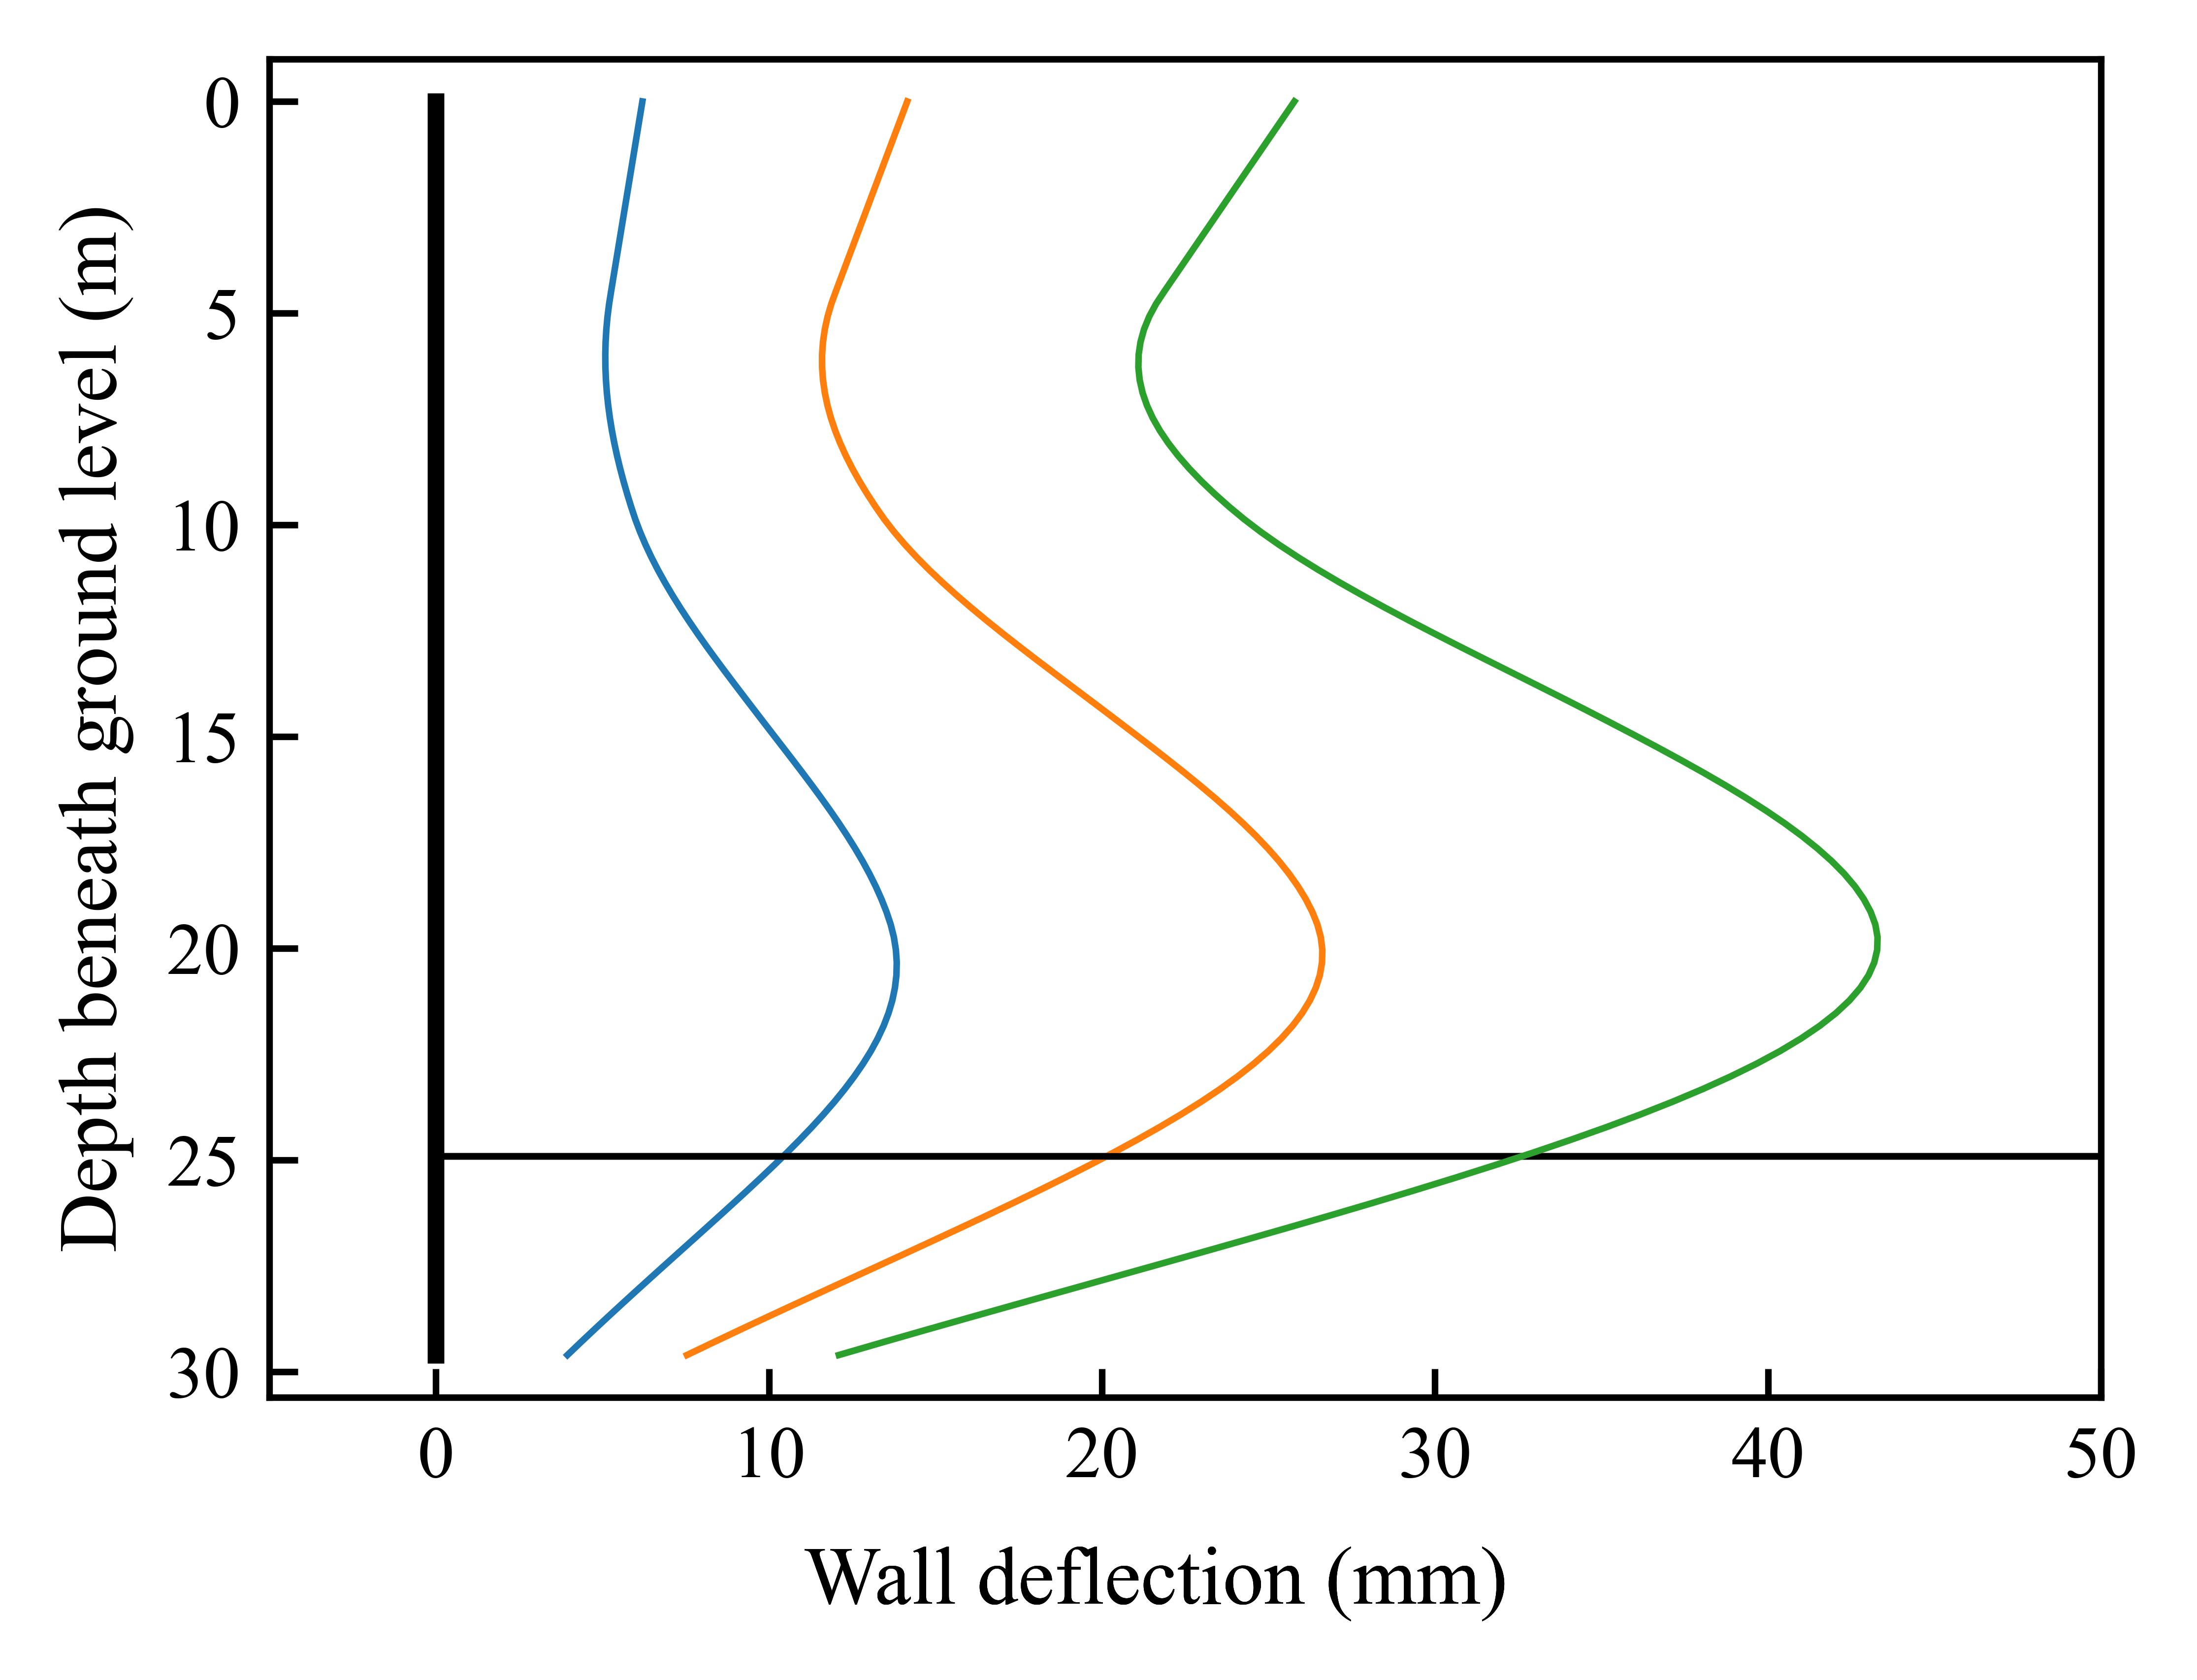

In [15]:
fig, ax = plt.subplots(
    1,
    1,
    figsize=(4,3), 
    dpi=1200, 
    sharey=False,
    sharex=True, 
    # squeeze=False, 
    constrained_layout=False
    )

lineprops = defaultdict(lambda: dict(lw=.8, ls="-", ms=5, mew=.6, fillstyle='none'))
linestyle = ["-"]
for bb, ls in zip(b_var, linestyle):
    lineprops[(bb)].update(ls="-")

stage = 5
plt.sca(ax)

for bb in b_var:
    output = Paper_param_var[
        (conc_E*conc_I_crack)+(steel_E*steel_I),
        40,
        11,
        1.25,
        gamma_50_standard,
        bb,
        20]

    ## Plotting of the MSD Method ##########################################################################################
    plt.plot([0,100], [output.Hm[stage-1],]*2, **lineprops[()], color="k") # Current excavation level
    plt.plot(np.multiply(output.x_points_total[stage-1],1000), output.y_points, **lineprops[(bb)], label=f"$b = {bb}, $" + r"$\gamma_{50} = $" + f"${g}$") # Total bulging deflection

    # ## Prop plotting
    # arrow_loc = np.interp(output.Hp[1], output.y_points, np.multiply(output.x_points_total[stage-1],1000))
    # ax.annotate("", xy=(arrow_loc-0.5, output.Hp[1]), xytext=(arrow_loc+5, output.Hp[1]), arrowprops=dict(arrowstyle="-|>", color='k'))
    # arrow_loc = np.interp(output.Hp[2], output.y_points, np.multiply(output.x_points_total[stage-1],1000))
    # ax.annotate("", xy=(arrow_loc-0.5, output.Hp[2]), xytext=(arrow_loc+5, output.Hp[2]), arrowprops=dict(arrowstyle="-|>", color='k'))
    # arrow_loc = np.interp(output.Hp[3], output.y_points, np.multiply(output.x_points_total[stage-1],1000))
    # ax.annotate("", xy=(arrow_loc-0.5, output.Hp[3]), xytext=(arrow_loc+5, output.Hp[3]), arrowprops=dict(arrowstyle="-|>", color='k'))
    # arrow_loc = np.interp(output.Hp[4], output.y_points, np.multiply(output.x_points_total[stage-1],1000))
    # ax.annotate("", xy=(arrow_loc-0.5, output.Hp[4]), xytext=(arrow_loc+5, output.Hp[4]), arrowprops=dict(arrowstyle="-|>", color='k'))
        
    plt.plot([0,0], [0,output.L], color='k', lw=2, ls='-') # Pile wall

    ## Formatting
    plt.ylim(output.L+1,0-1)
    plt.xlim(-5,50)
    plt.ylabel("Depth beneath ground level (m)", fontsize=axsfs)
    plt.figtext(0.5,0.02, "Wall deflection (mm)", ha="center", va="center", fontsize=axsfs)
    # plt.legend(frameon=False, bbox_to_anchor=[1.2,0.25])

### gamma_50

In [17]:
fig, axs = plt.subplots(
    1,
    1,
    figsize=(4,3), 
    dpi=1200, 
    sharey=False,
    sharex=True, 
    # squeeze=False, 
    constrained_layout=False
    )

lineprops = defaultdict(lambda: dict(lw=.8, ls="-.", color='k', ms=5, mew=.6, fillstyle='none'))
linestyle = ["-", "-", ":"]
for g, ls in zip(gamma_50_var, linestyle):
    lineprops[(g)].update(ls=ls)

stage = 5
plt.sca(axs)

for g in gamma_50_var:
    output = Paper_param_var[
        (conc_E*conc_I_crack)+(steel_E*steel_I),
        40,
        11,
        1.25,
        g,
        0.58,
        20]

    ## Plotting of the MSD Method ##########################################################################################
    plt.plot([0,100], [output.Hm[stage-1],]*2, **lineprops[()]) # Current excavation level
    plt.plot(np.multiply(output.x_points_total[stage-1],1000), output.y_points, **lineprops[(g)], label="$\gamma_{50}$ = "f"{g}") # Total bulging deflection

    ## Prop plotting
    arrow_loc = np.interp(output.Hp[1], output.y_points, np.multiply(output.x_points_total[stage-1],1000))
    ax.annotate("", xy=(arrow_loc-0.5, output.Hp[1]), xytext=(arrow_loc+5, output.Hp[1]), arrowprops=dict(arrowstyle="-|>", color='k'))
    arrow_loc = np.interp(output.Hp[2], output.y_points, np.multiply(output.x_points_total[stage-1],1000))
    ax.annotate("", xy=(arrow_loc-0.5, output.Hp[2]), xytext=(arrow_loc+5, output.Hp[2]), arrowprops=dict(arrowstyle="-|>", color='k'))
    arrow_loc = np.interp(output.Hp[3], output.y_points, np.multiply(output.x_points_total[stage-1],1000))
    ax.annotate("", xy=(arrow_loc-0.5, output.Hp[3]), xytext=(arrow_loc+5, output.Hp[3]), arrowprops=dict(arrowstyle="-|>", color='k'))
    arrow_loc = np.interp(output.Hp[4], output.y_points, np.multiply(output.x_points_total[stage-1],1000))
    ax.annotate("", xy=(arrow_loc-0.5, output.Hp[4]), xytext=(arrow_loc+5, output.Hp[4]), arrowprops=dict(arrowstyle="-|>", color='k'))
        
    plt.plot([0,0], [0,output.L], color='k', lw=2, ls='-') # Pile wall

    ## Formatting
    plt.ylim(output.L+1,0-1)
    plt.xlim(-5,50)
    plt.ylabel("Depth beneath ground level (m)", fontsize=axsfs)
    plt.figtext(0.5,0.02, "Wall deflection (mm)", ha="center", va="center", fontsize=axsfs)
    plt.legend(frameon=False)

### gamma_sat

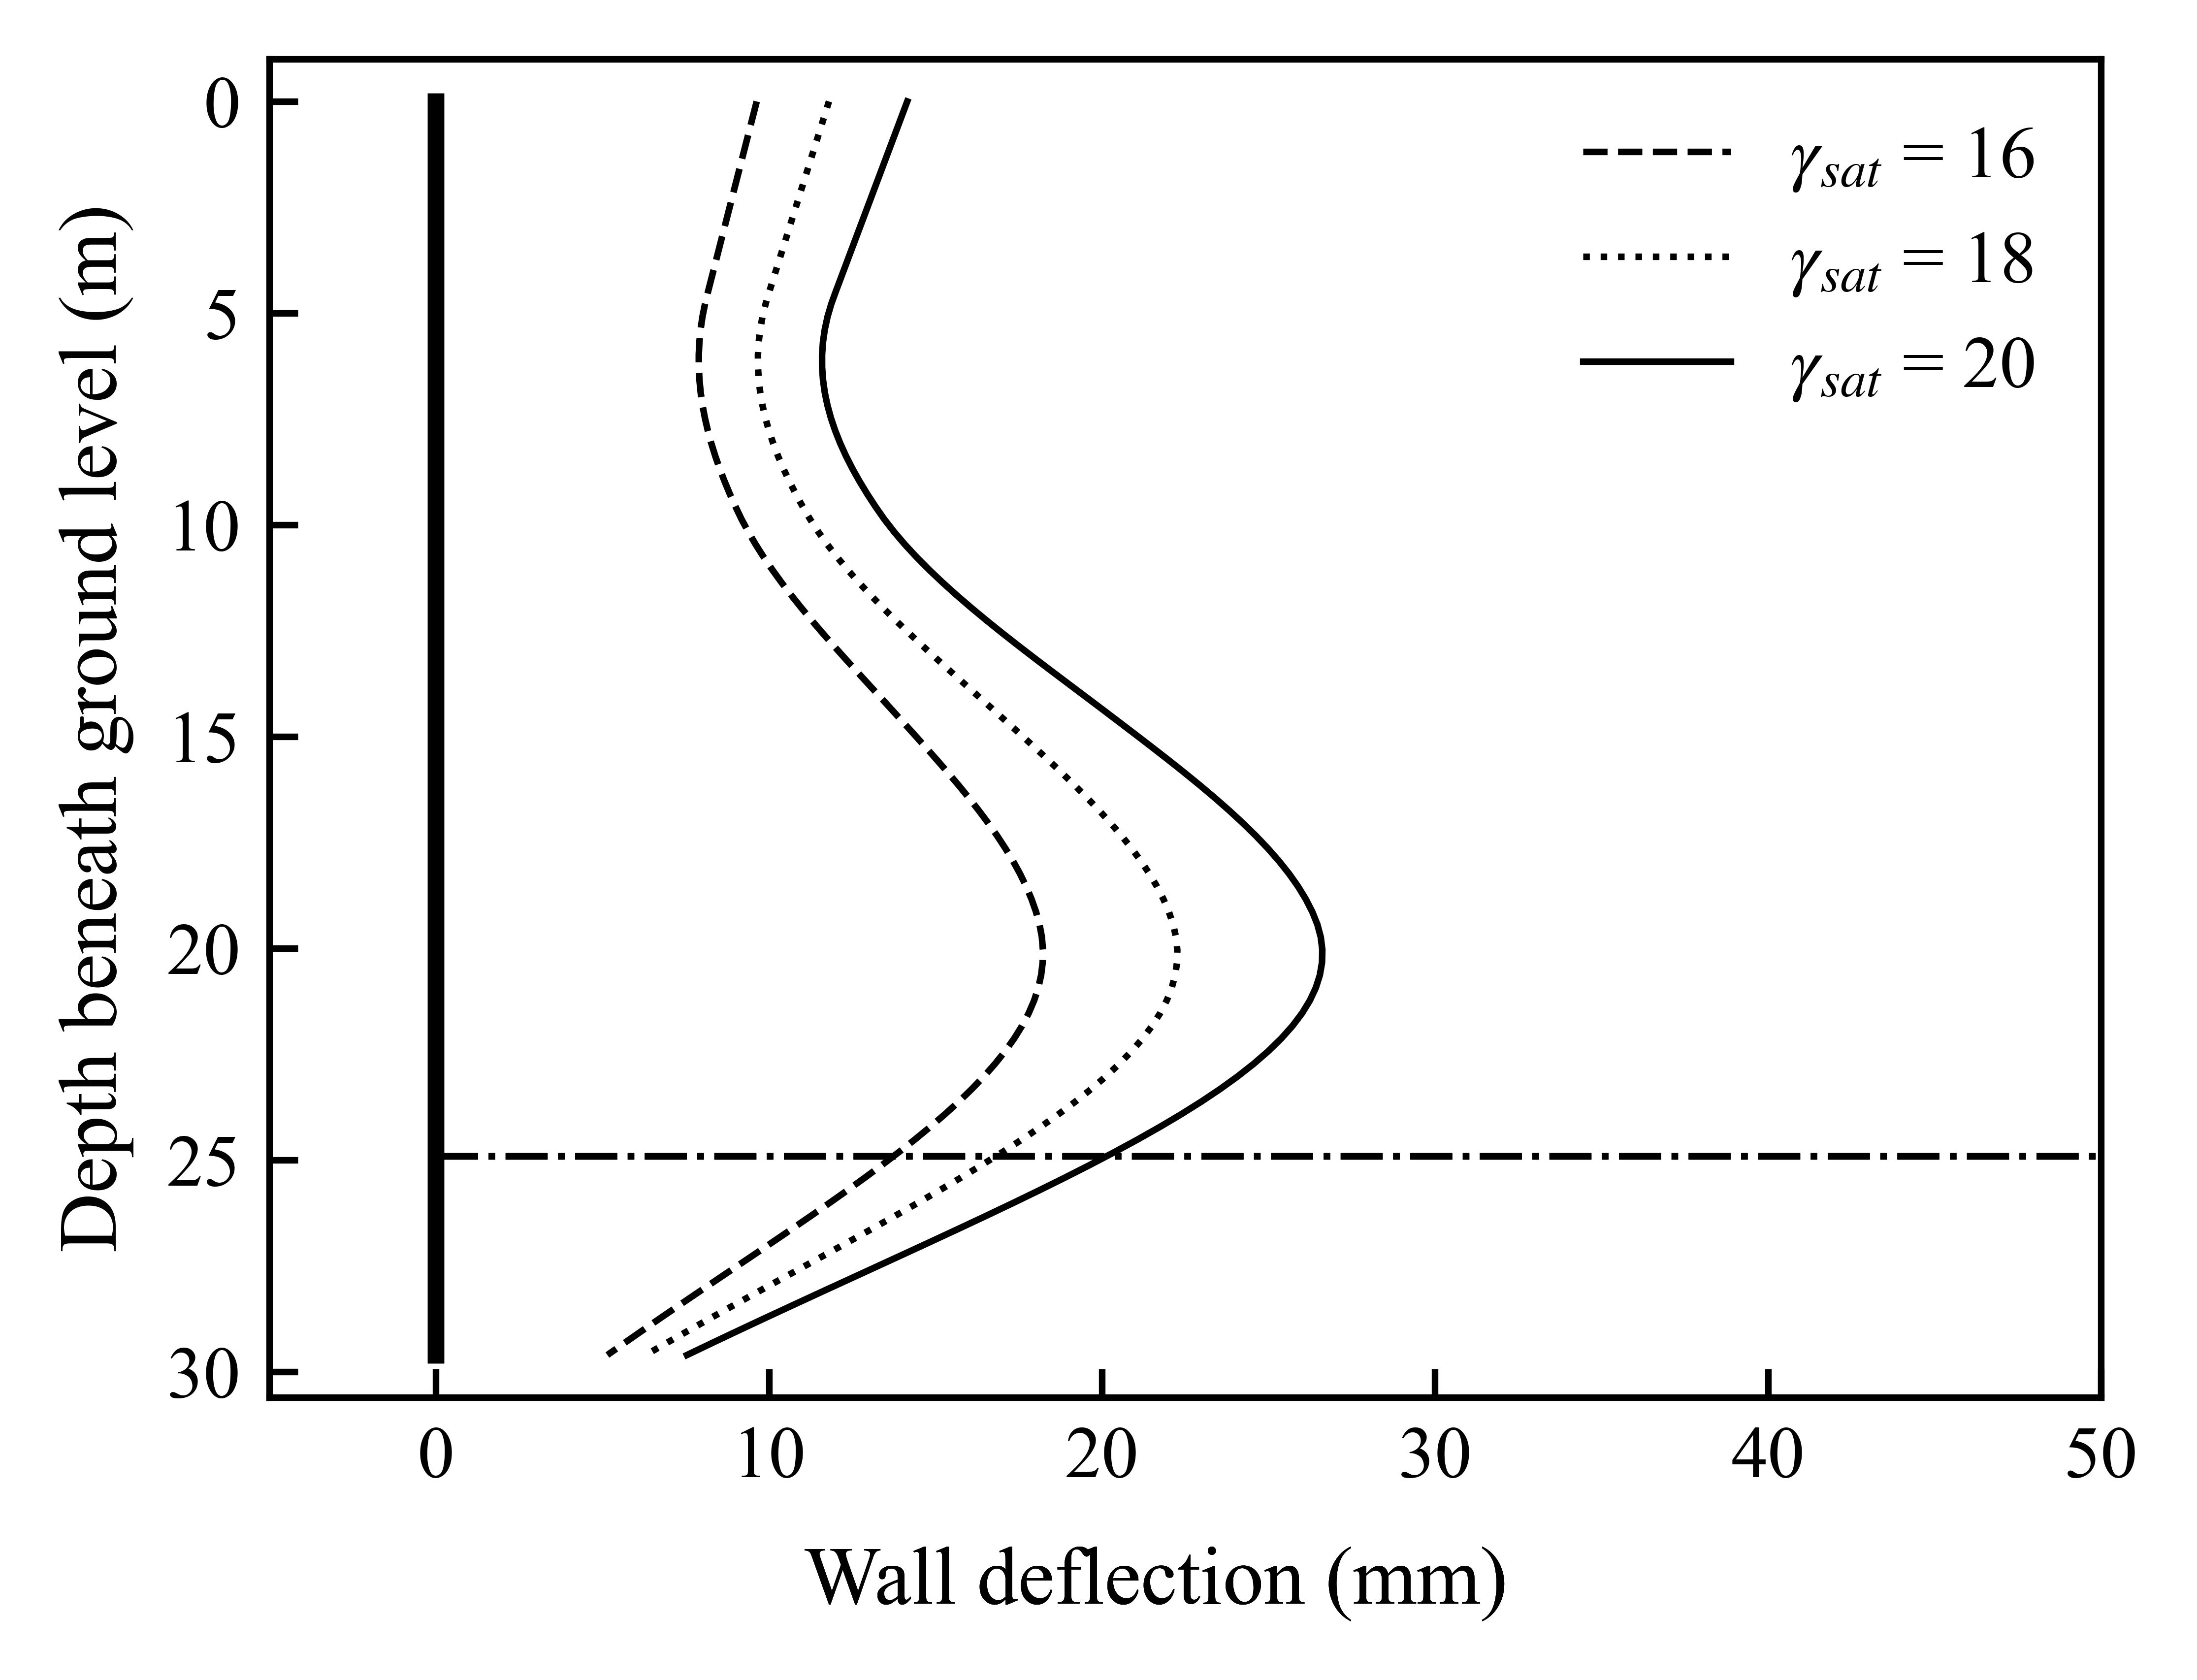

In [18]:
fig, axs = plt.subplots(
    1,
    1,
    figsize=(4,3), 
    dpi=1200, 
    sharey=False,
    sharex=True, 
    # squeeze=False, 
    constrained_layout=False
    )

lineprops = defaultdict(lambda: dict(lw=.8, ls="-.", color='k', ms=5, mew=.6, fillstyle='none'))
linestyle = ["--", ":", "-"]
for gs, ls in zip(gamma_sat_var, linestyle):
    lineprops[(gs)].update(ls=ls)

stage = 5
plt.sca(axs)

for gs in gamma_sat_var:
    output = Paper_param_var[
        (conc_E*conc_I_crack)+(steel_E*steel_I),
        40,
        11,
        1.25,
        0.007,
        0.58,
        gs,
        ]

    ## Plotting of the MSD Method ##########################################################################################
    plt.plot([0,100], [output.Hm[stage-1],]*2, **lineprops[()]) # Current excavation level
    plt.plot(np.multiply(output.x_points_total[stage-1],1000), output.y_points, **lineprops[(gs)], label="$\gamma_{sat}$ = "f"{gs}") # Total bulging deflection

    ## Prop plotting
    arrow_loc = np.interp(output.Hp[1], output.y_points, np.multiply(output.x_points_total[stage-1],1000))
    ax.annotate("", xy=(arrow_loc-0.5, output.Hp[1]), xytext=(arrow_loc+5, output.Hp[1]), arrowprops=dict(arrowstyle="-|>", color='k'))
    arrow_loc = np.interp(output.Hp[2], output.y_points, np.multiply(output.x_points_total[stage-1],1000))
    ax.annotate("", xy=(arrow_loc-0.5, output.Hp[2]), xytext=(arrow_loc+5, output.Hp[2]), arrowprops=dict(arrowstyle="-|>", color='k'))
    arrow_loc = np.interp(output.Hp[3], output.y_points, np.multiply(output.x_points_total[stage-1],1000))
    ax.annotate("", xy=(arrow_loc-0.5, output.Hp[3]), xytext=(arrow_loc+5, output.Hp[3]), arrowprops=dict(arrowstyle="-|>", color='k'))
    arrow_loc = np.interp(output.Hp[4], output.y_points, np.multiply(output.x_points_total[stage-1],1000))
    ax.annotate("", xy=(arrow_loc-0.5, output.Hp[4]), xytext=(arrow_loc+5, output.Hp[4]), arrowprops=dict(arrowstyle="-|>", color='k'))
        
    plt.plot([0,0], [0,output.L], color='k', lw=2, ls='-') # Pile wall

    ## Formatting
    plt.ylim(output.L+1,0-1)
    plt.xlim(-5,50)
    plt.ylabel("Depth beneath ground level (m)", fontsize=axsfs)
    plt.figtext(0.5,0.02, "Wall deflection (mm)", ha="center", va="center", fontsize=axsfs)
    plt.legend(frameon=False)

### cu

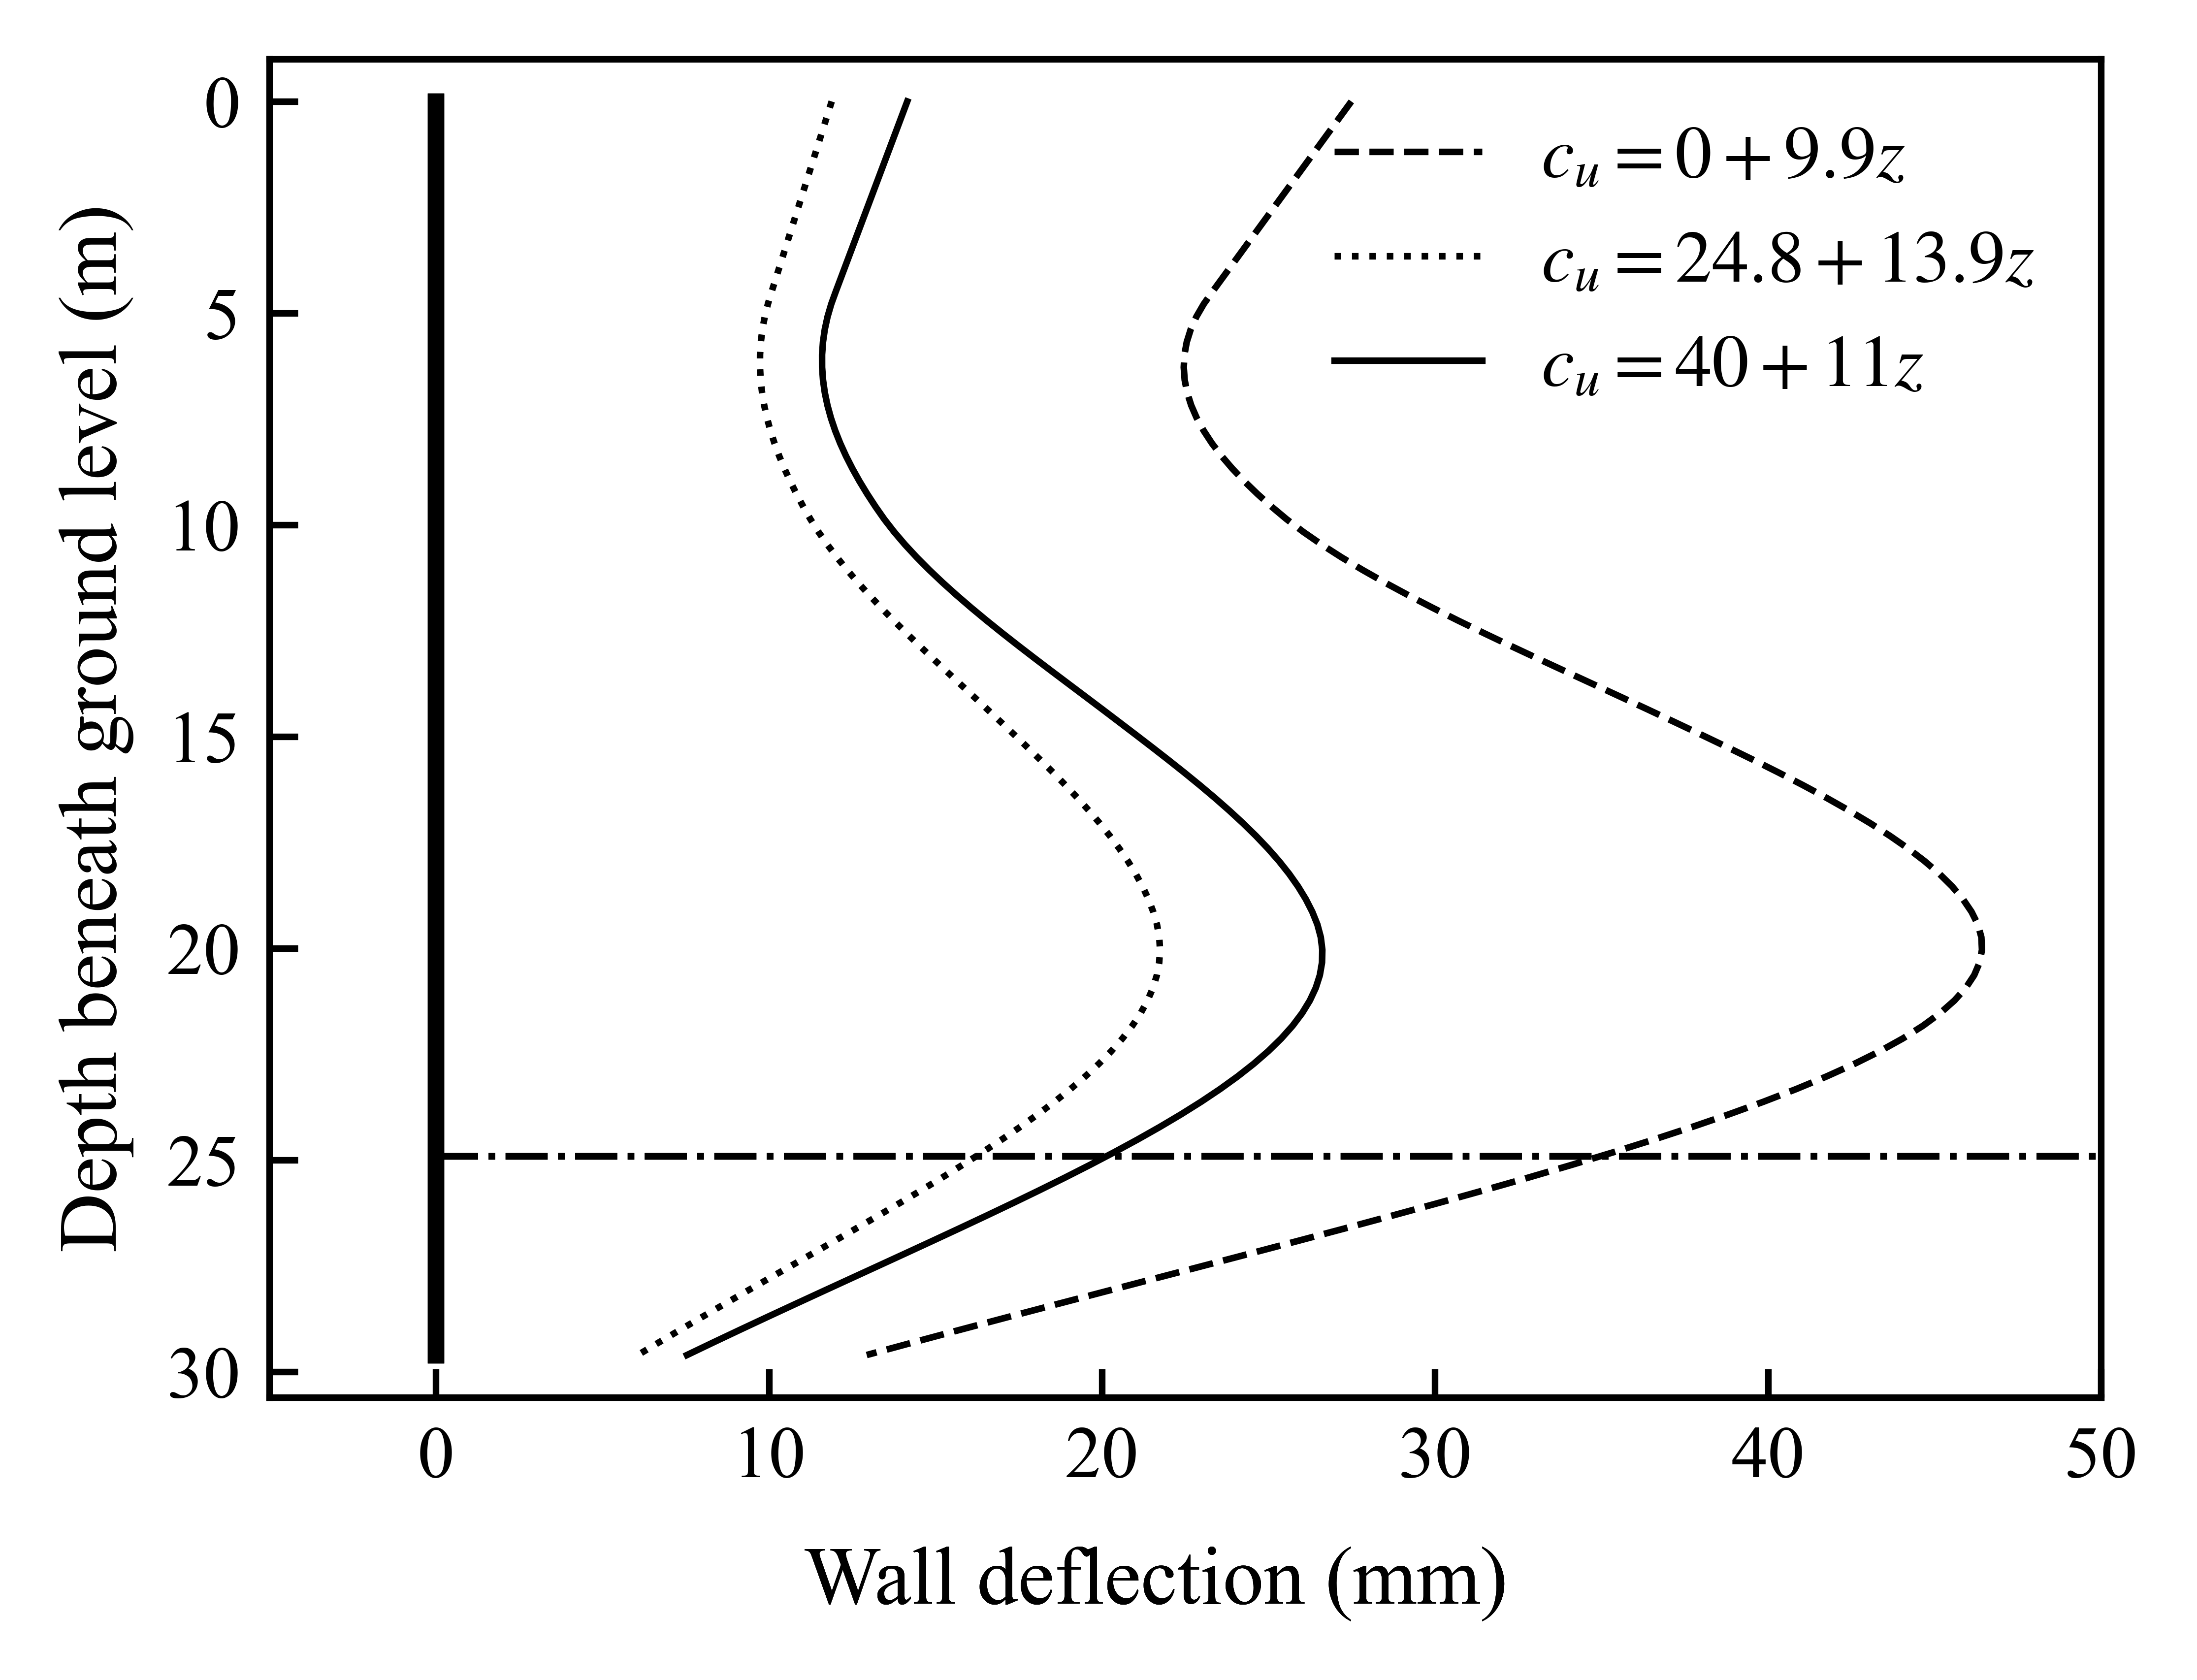

In [20]:
fig, axs = plt.subplots(
    1,
    1,
    figsize=(4,3), 
    dpi=1200, 
    sharey=False,
    sharex=True, 
    # squeeze=False, 
    constrained_layout=False
    )

lineprops = defaultdict(lambda: dict(lw=.8, ls="-.", color='k', ms=5, mew=.6, fillstyle='none'))
linestyle = ["--", ":", "-"]
for c, ls in zip(cu_var, linestyle):
    lineprops[(c)].update(ls=ls)

stage = 5
plt.sca(axs)

for c,v in zip(cu_var,cu_var_var):
    output = Paper_param_var[
        (conc_E*conc_I_crack)+(steel_E*steel_I),
        c,
        v,
        1.25,
        0.007,
        0.58,
        20,
        ]

    ## Plotting of the MSD Method ##########################################################################################
    plt.plot([0,100], [output.Hm[stage-1],]*2, **lineprops[()]) # Current excavation level
    plt.plot(np.multiply(output.x_points_total[stage-1],1000), output.y_points, **lineprops[(c)], label=f"$c_u = {c} + {v}z$") # Total bulging deflection

    ## Prop plotting
    arrow_loc = np.interp(output.Hp[1], output.y_points, np.multiply(output.x_points_total[stage-1],1000))
    ax.annotate("", xy=(arrow_loc-0.5, output.Hp[1]), xytext=(arrow_loc+5, output.Hp[1]), arrowprops=dict(arrowstyle="-|>", color='k'))
    arrow_loc = np.interp(output.Hp[2], output.y_points, np.multiply(output.x_points_total[stage-1],1000))
    ax.annotate("", xy=(arrow_loc-0.5, output.Hp[2]), xytext=(arrow_loc+5, output.Hp[2]), arrowprops=dict(arrowstyle="-|>", color='k'))
    arrow_loc = np.interp(output.Hp[3], output.y_points, np.multiply(output.x_points_total[stage-1],1000))
    ax.annotate("", xy=(arrow_loc-0.5, output.Hp[3]), xytext=(arrow_loc+5, output.Hp[3]), arrowprops=dict(arrowstyle="-|>", color='k'))
    arrow_loc = np.interp(output.Hp[4], output.y_points, np.multiply(output.x_points_total[stage-1],1000))
    ax.annotate("", xy=(arrow_loc-0.5, output.Hp[4]), xytext=(arrow_loc+5, output.Hp[4]), arrowprops=dict(arrowstyle="-|>", color='k'))
        
    plt.plot([0,0], [0,output.L], color='k', lw=2, ls='-') # Pile wall

    ## Formatting
    plt.ylim(output.L+1,0-1)
    plt.xlim(-5,50)
    plt.ylabel("Depth beneath ground level (m)", fontsize=axsfs)
    plt.figtext(0.5,0.02, "Wall deflection (mm)", ha="center", va="center", fontsize=axsfs)
    plt.legend(frameon=False)

### EI

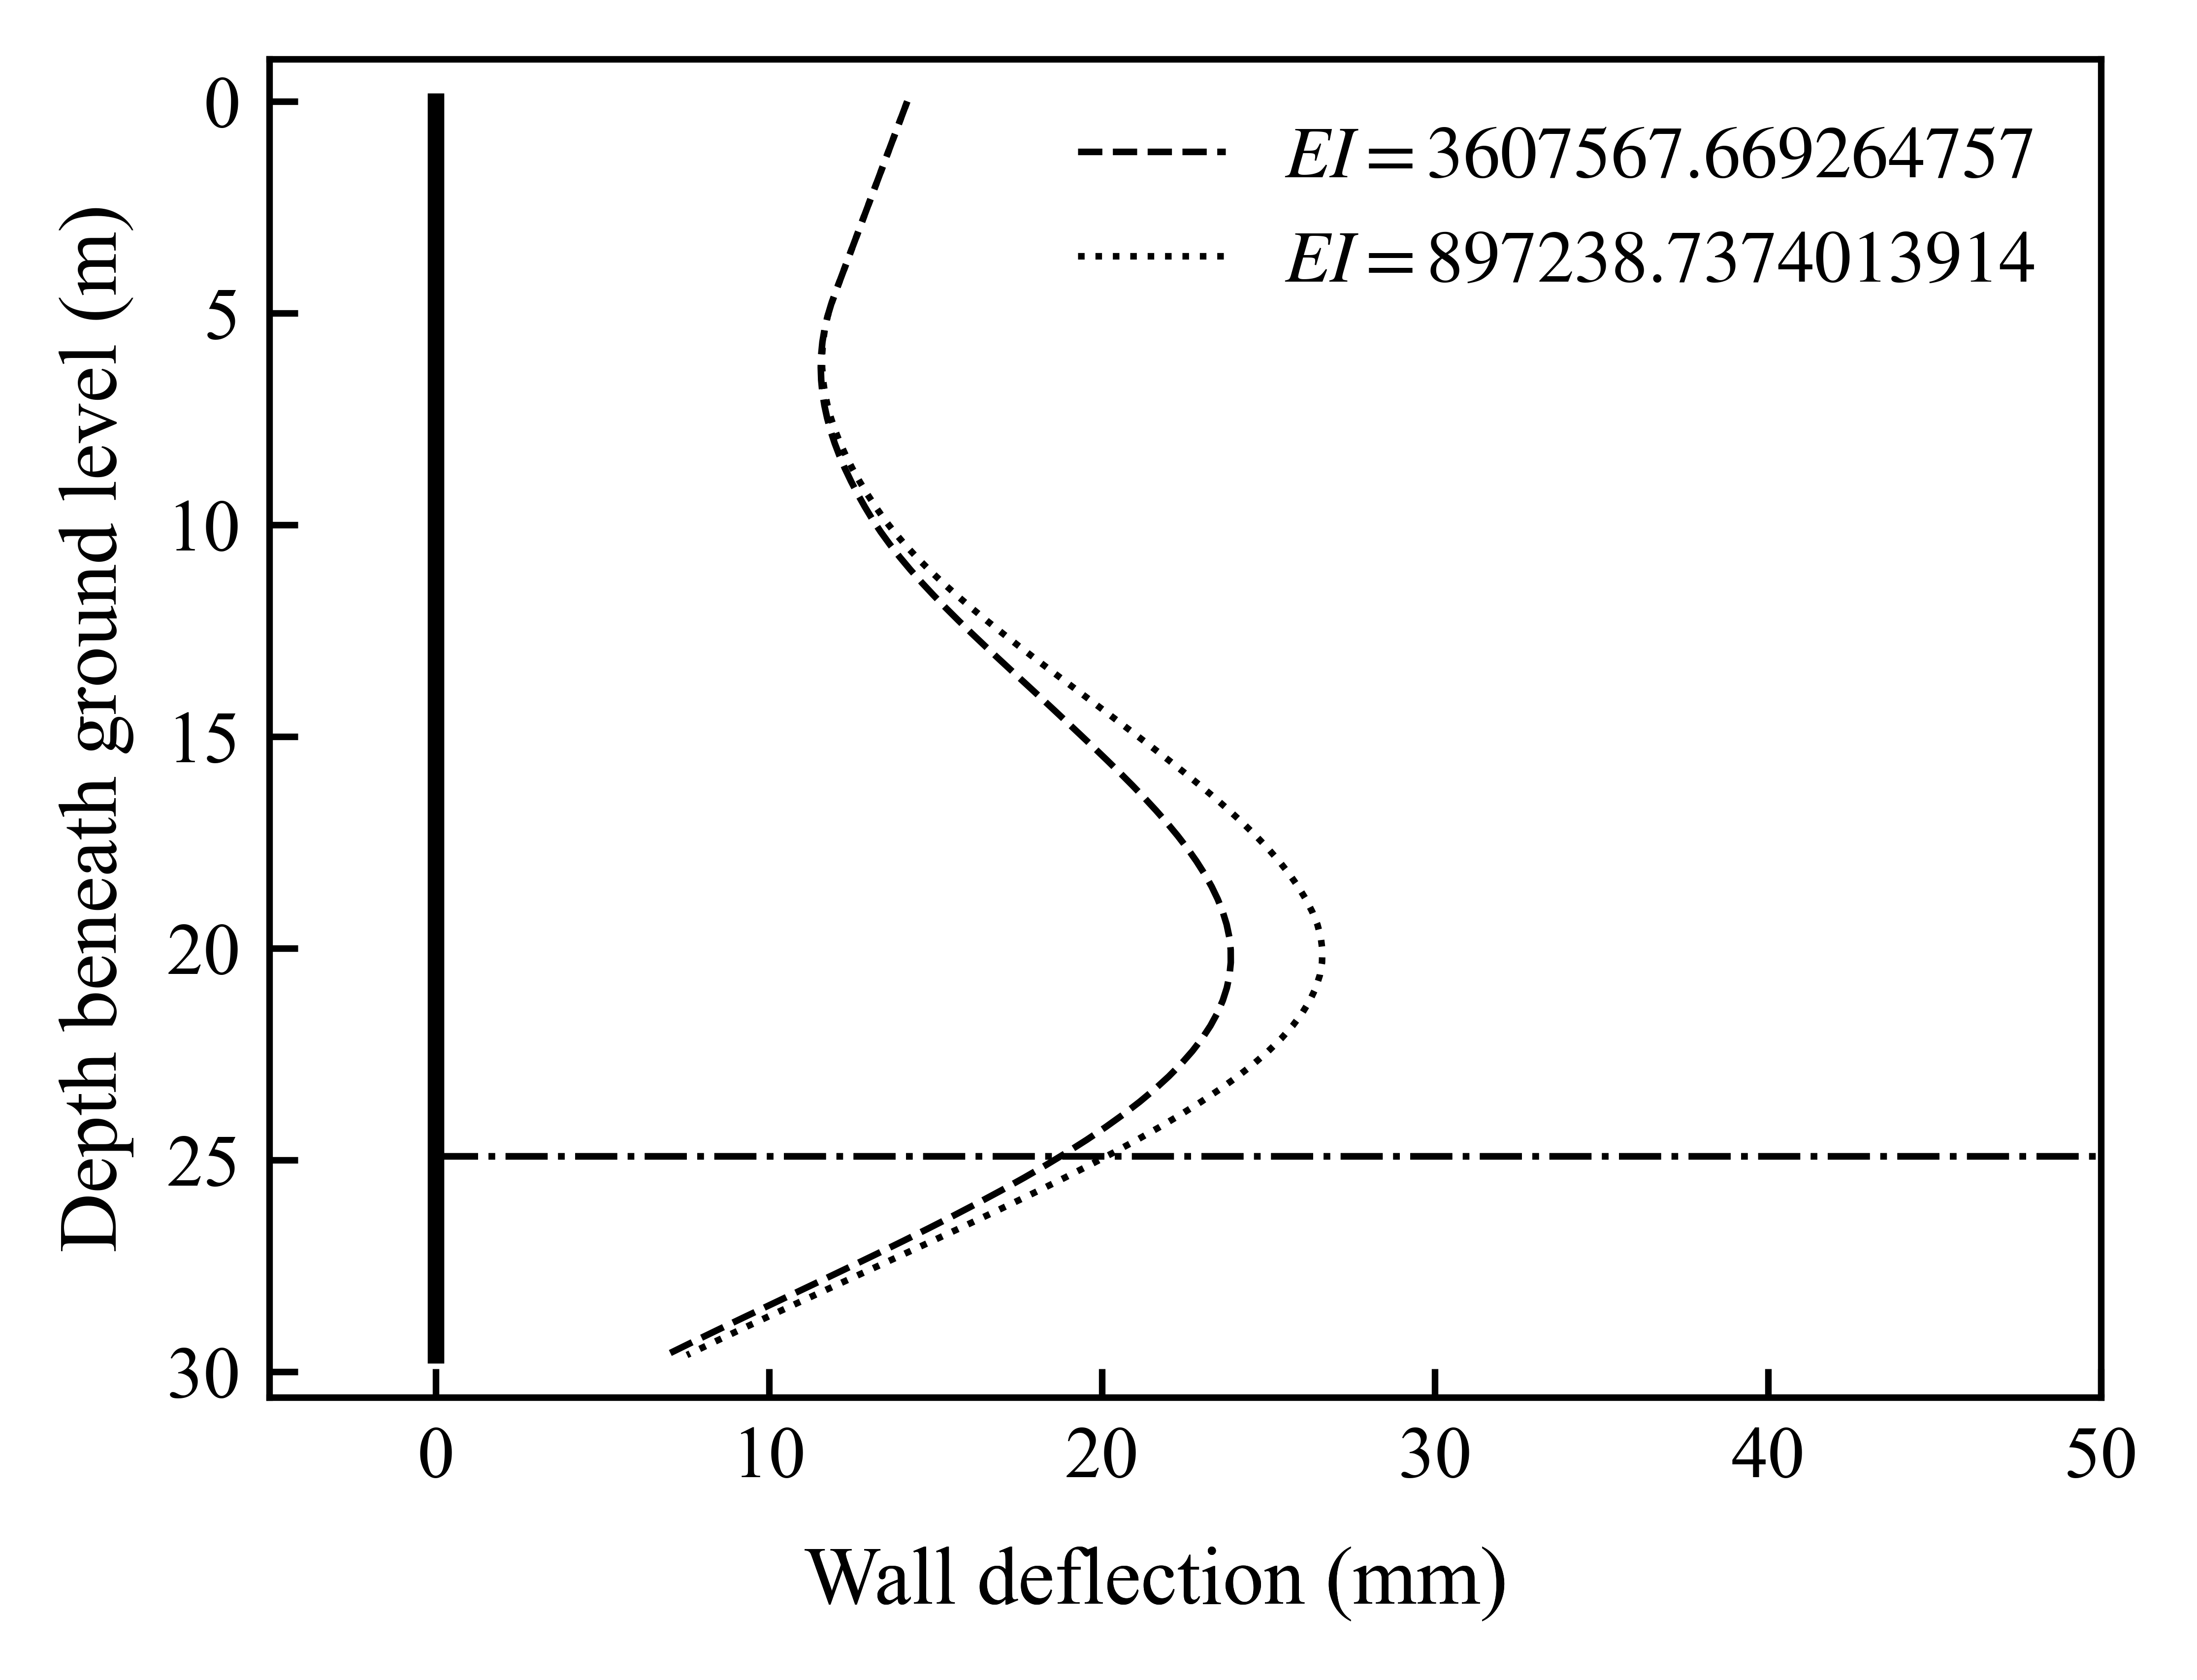

In [25]:
fig, axs = plt.subplots(
    1,
    1,
    figsize=(4,3), 
    dpi=1200, 
    sharey=False,
    sharex=True, 
    # squeeze=False, 
    constrained_layout=False
    )

lineprops = defaultdict(lambda: dict(lw=.8, ls="-.", color='k', ms=5, mew=.6, fillstyle='none'))
linestyle = ["--", ":", "-"]
for ei, ls in zip(EI_var, linestyle):
    lineprops[(ei)].update(ls=ls)

stage = 5
plt.sca(axs)

for ei in EI_var:
    output = Paper_param_var[
        ei,
        40,
        11,
        1.25,
        0.007,
        0.58,
        20,
        ]

    ## Plotting of the MSD Method ##########################################################################################
    plt.plot([0,100], [output.Hm[stage-1],]*2, **lineprops[()]) # Current excavation level
    plt.plot(np.multiply(output.x_points_total[stage-1],1000), output.y_points, **lineprops[(ei)], label=f"$EI = {ei}$") # Total bulging deflection

    ## Prop plotting
    arrow_loc = np.interp(output.Hp[1], output.y_points, np.multiply(output.x_points_total[stage-1],1000))
    ax.annotate("", xy=(arrow_loc-0.5, output.Hp[1]), xytext=(arrow_loc+5, output.Hp[1]), arrowprops=dict(arrowstyle="-|>", color='k'))
    arrow_loc = np.interp(output.Hp[2], output.y_points, np.multiply(output.x_points_total[stage-1],1000))
    ax.annotate("", xy=(arrow_loc-0.5, output.Hp[2]), xytext=(arrow_loc+5, output.Hp[2]), arrowprops=dict(arrowstyle="-|>", color='k'))
    arrow_loc = np.interp(output.Hp[3], output.y_points, np.multiply(output.x_points_total[stage-1],1000))
    ax.annotate("", xy=(arrow_loc-0.5, output.Hp[3]), xytext=(arrow_loc+5, output.Hp[3]), arrowprops=dict(arrowstyle="-|>", color='k'))
    arrow_loc = np.interp(output.Hp[4], output.y_points, np.multiply(output.x_points_total[stage-1],1000))
    ax.annotate("", xy=(arrow_loc-0.5, output.Hp[4]), xytext=(arrow_loc+5, output.Hp[4]), arrowprops=dict(arrowstyle="-|>", color='k'))
        
    plt.plot([0,0], [0,output.L], color='k', lw=2, ls='-') # Pile wall

    ## Formatting
    plt.ylim(output.L+1,0-1)
    plt.xlim(-5,50)
    plt.ylabel("Depth beneath ground level (m)", fontsize=axsfs)
    plt.figtext(0.5,0.02, "Wall deflection (mm)", ha="center", va="center", fontsize=axsfs)
    plt.legend(frameon=False)

### Alpha

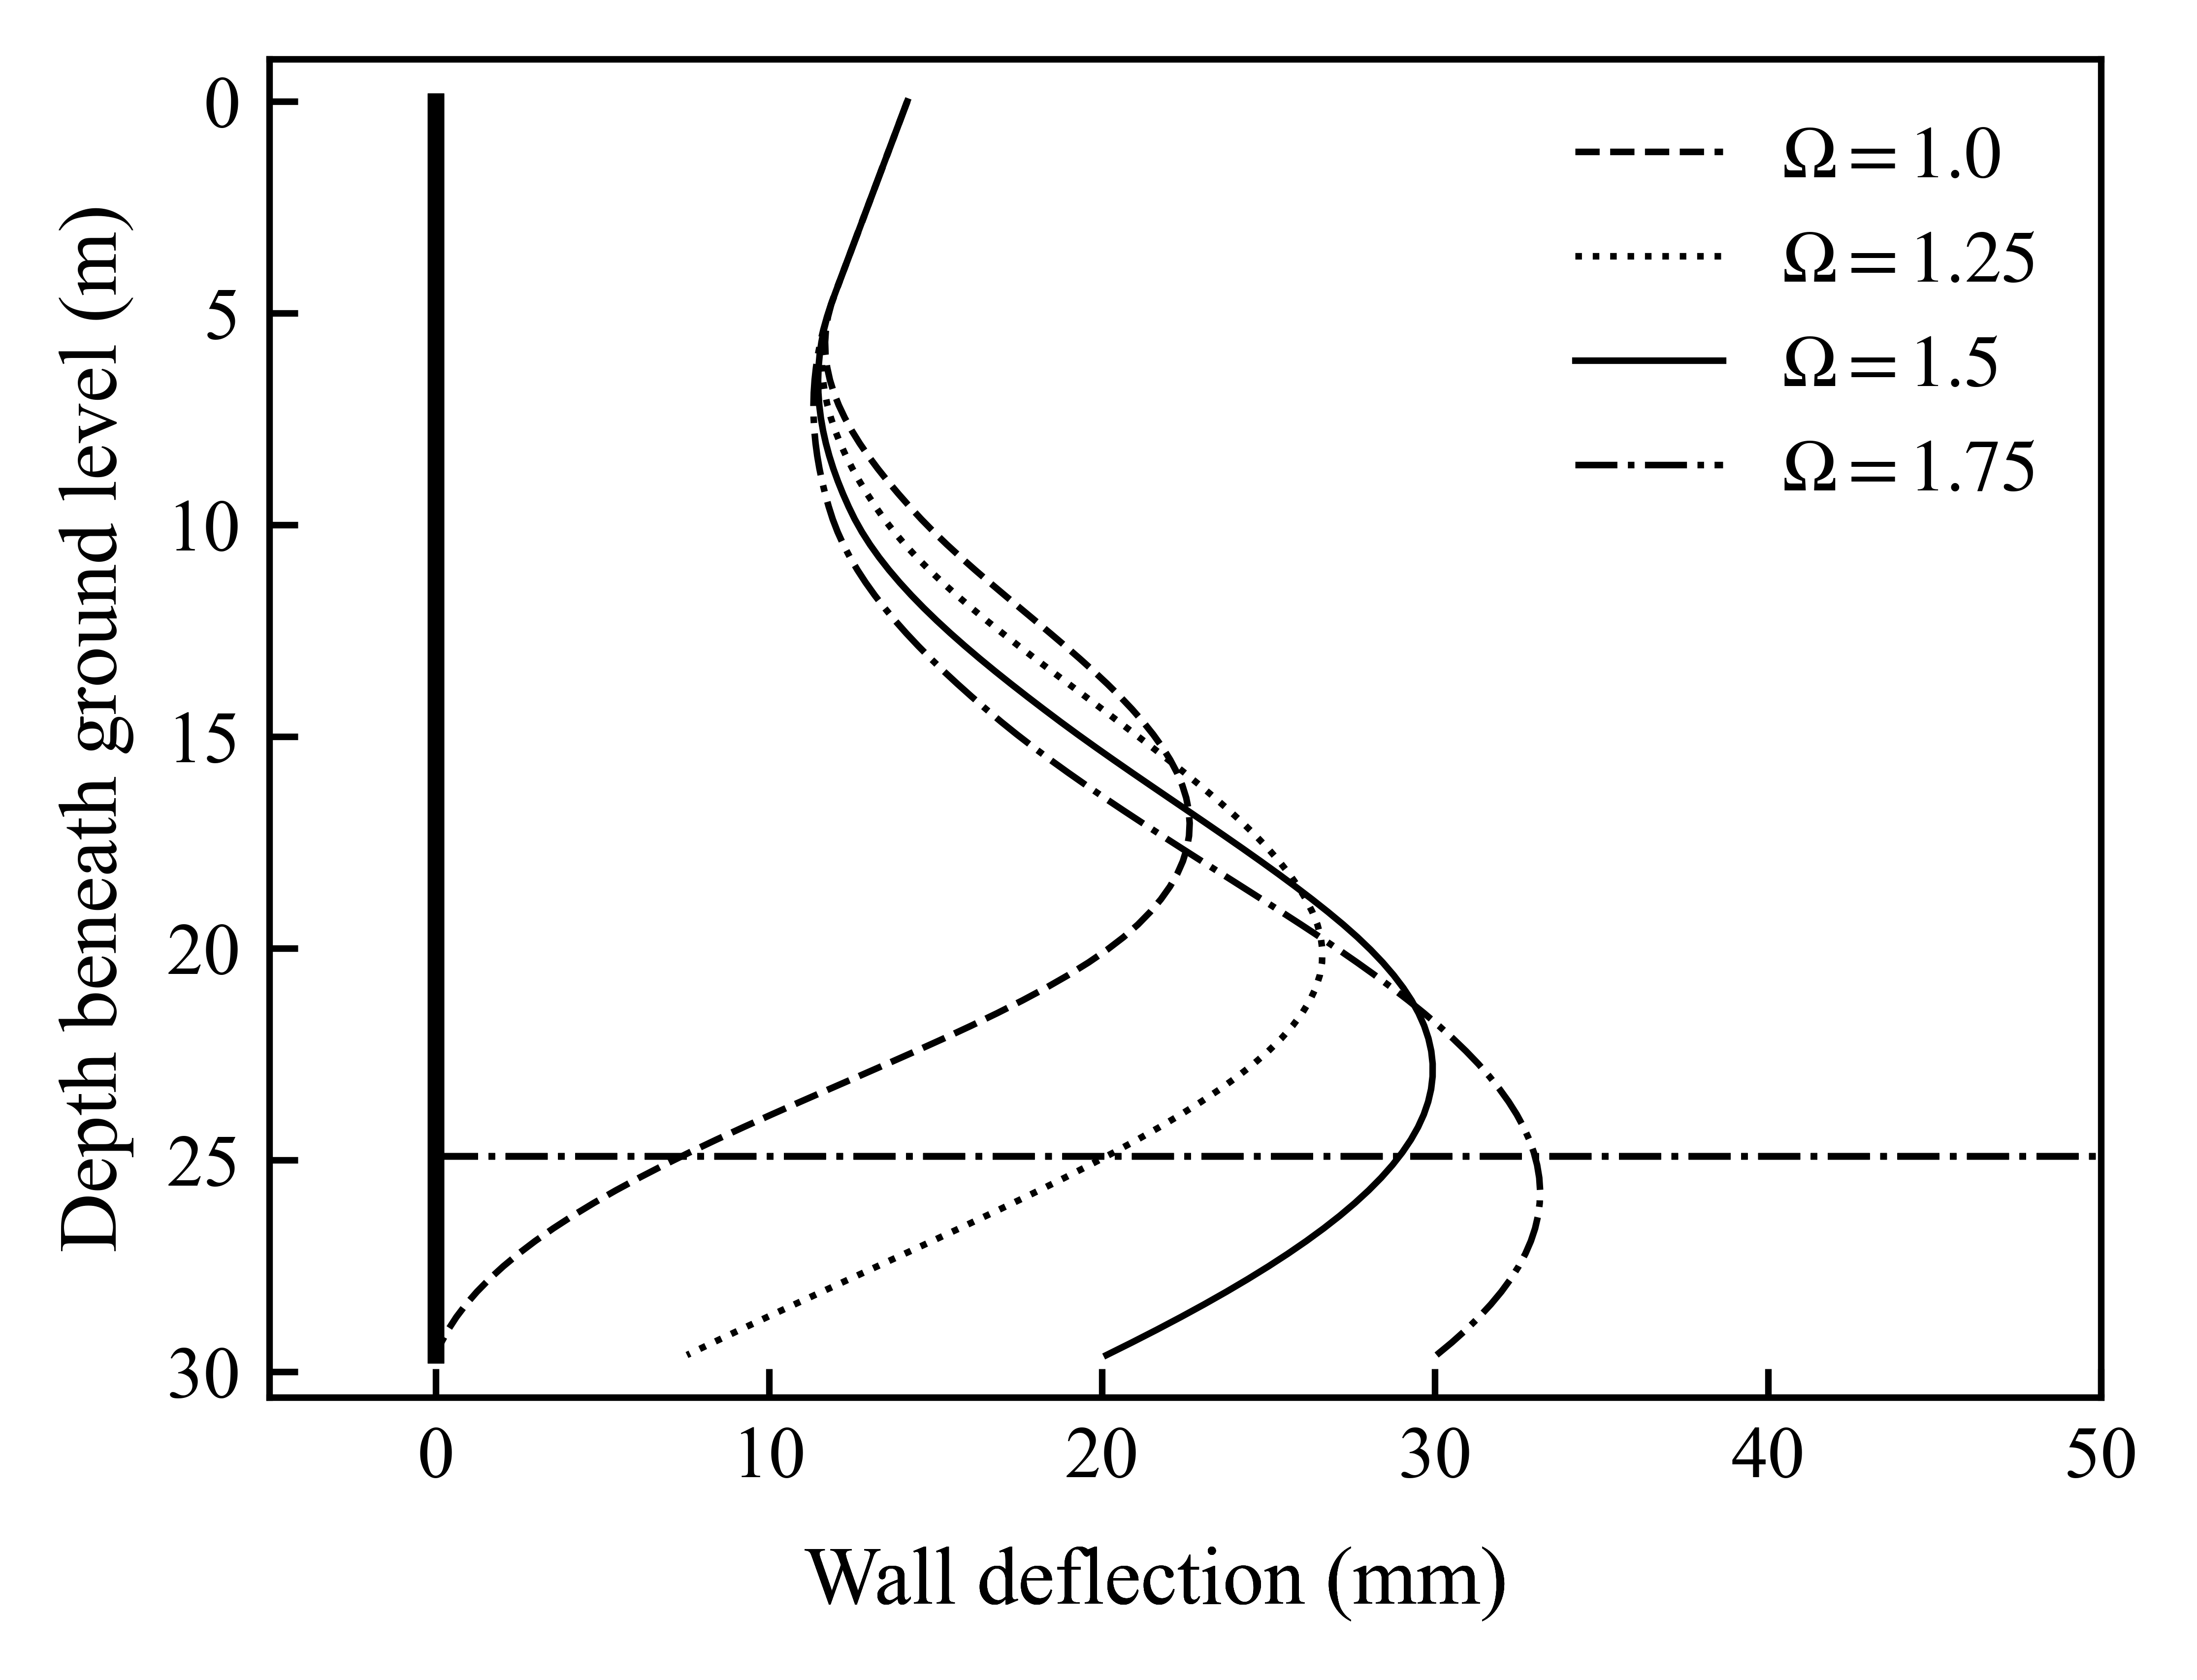

In [26]:
fig, axs = plt.subplots(
    1,
    1,
    figsize=(4,3), 
    dpi=1200, 
    sharey=False,
    sharex=True, 
    # squeeze=False, 
    constrained_layout=False
    )

lineprops = defaultdict(lambda: dict(lw=.8, ls="-.", color='k', ms=5, mew=.6, fillstyle='none'))
linestyle = ["--", ":", "-", "-."]
for a, ls in zip(alpha_var, linestyle):
    lineprops[(a)].update(ls=ls)

stage = 5
plt.sca(axs)

for a in alpha_var:
    output = Paper_param_var[
        (conc_E*conc_I_crack)+(steel_E*steel_I),
        40,
        11,
        a,
        0.007,
        0.58,
        20,
        ]

    ## Plotting of the MSD Method ##########################################################################################
    plt.plot([0,100], [output.Hm[stage-1],]*2, **lineprops[()]) # Current excavation level
    plt.plot(np.multiply(output.x_points_total[stage-1],1000), output.y_points, **lineprops[(a)], label="$\Omega = "f"{a}$") # Total bulging deflection

    ## Prop plotting
    arrow_loc = np.interp(output.Hp[1], output.y_points, np.multiply(output.x_points_total[stage-1],1000))
    ax.annotate("", xy=(arrow_loc-0.5, output.Hp[1]), xytext=(arrow_loc+5, output.Hp[1]), arrowprops=dict(arrowstyle="-|>", color='k'))
    arrow_loc = np.interp(output.Hp[2], output.y_points, np.multiply(output.x_points_total[stage-1],1000))
    ax.annotate("", xy=(arrow_loc-0.5, output.Hp[2]), xytext=(arrow_loc+5, output.Hp[2]), arrowprops=dict(arrowstyle="-|>", color='k'))
    arrow_loc = np.interp(output.Hp[3], output.y_points, np.multiply(output.x_points_total[stage-1],1000))
    ax.annotate("", xy=(arrow_loc-0.5, output.Hp[3]), xytext=(arrow_loc+5, output.Hp[3]), arrowprops=dict(arrowstyle="-|>", color='k'))
    arrow_loc = np.interp(output.Hp[4], output.y_points, np.multiply(output.x_points_total[stage-1],1000))
    ax.annotate("", xy=(arrow_loc-0.5, output.Hp[4]), xytext=(arrow_loc+5, output.Hp[4]), arrowprops=dict(arrowstyle="-|>", color='k'))
        
    plt.plot([0,0], [0,output.L], color='k', lw=2, ls='-') # Pile wall

    ## Formatting
    plt.ylim(output.L+1,0-1)
    plt.xlim(-5,50)
    plt.ylabel("Depth beneath ground level (m)", fontsize=axsfs)
    plt.figtext(0.5,0.02, "Wall deflection (mm)", ha="center", va="center", fontsize=axsfs)
    plt.legend(frameon=False)

### Figure 3

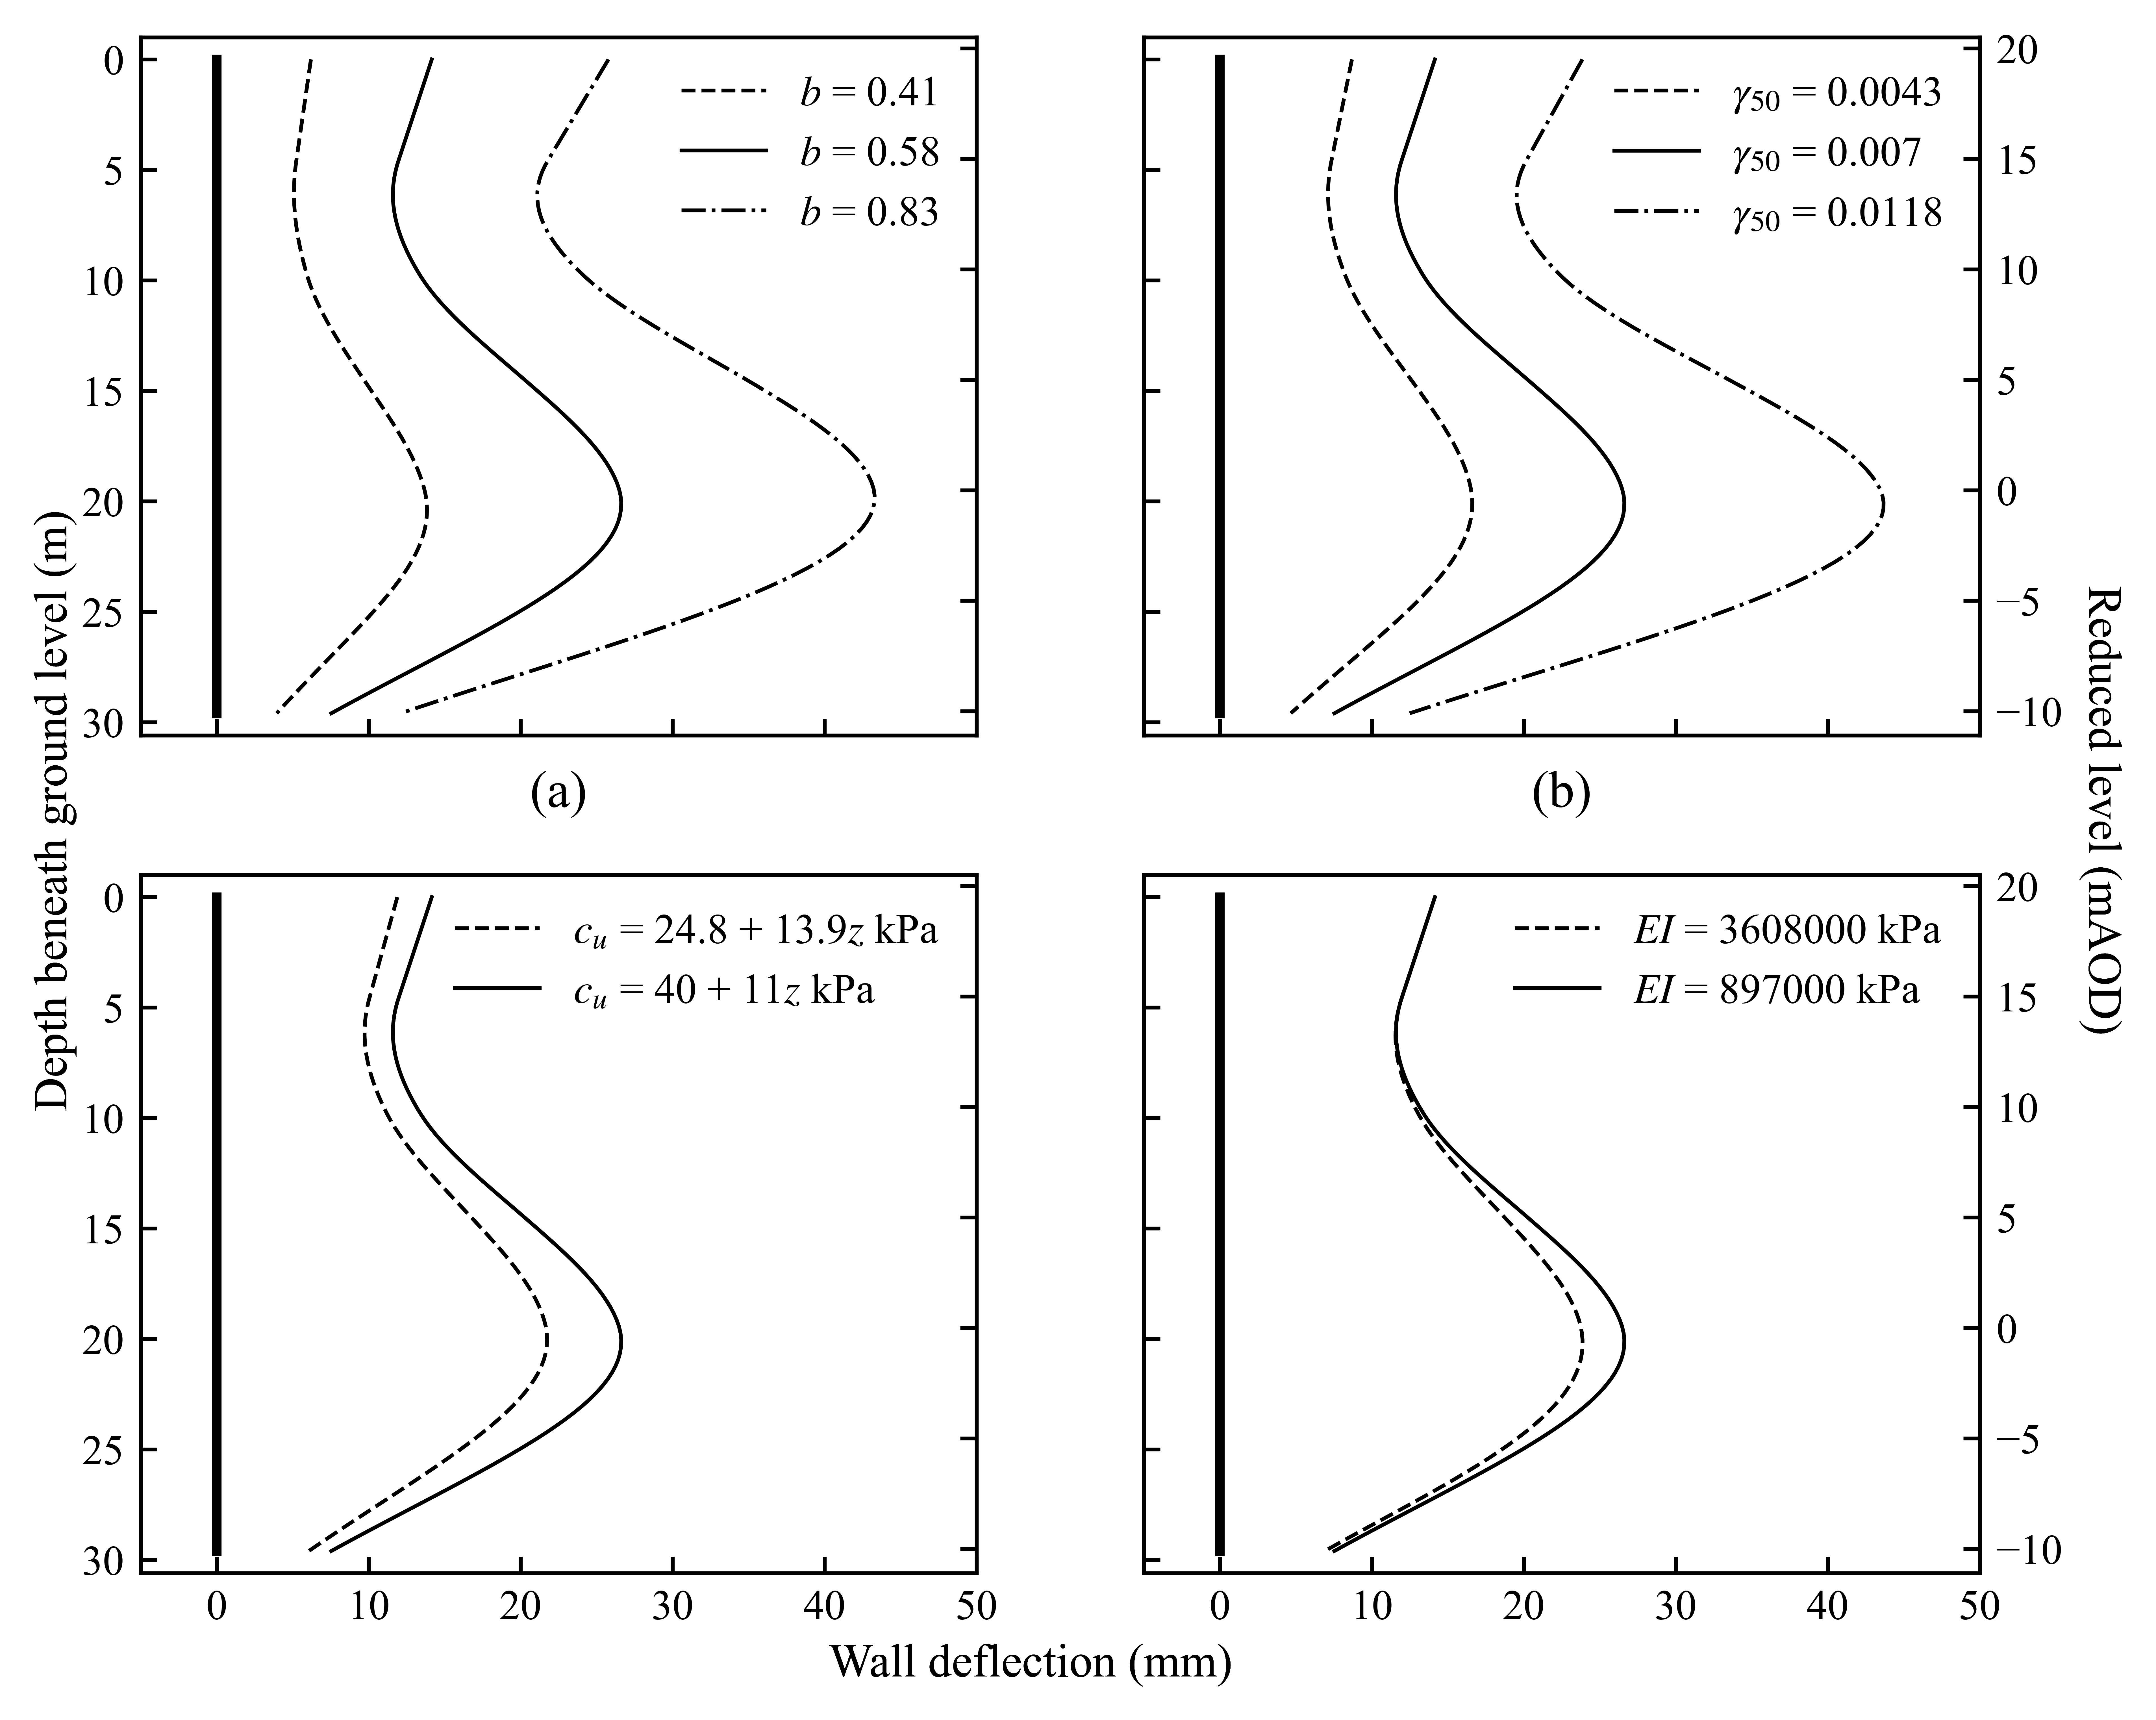

In [177]:
fig, axs = plt.subplots(
    2,
    2,
    figsize=(7,6), 
    dpi=1200, 
    sharey=False,
    sharex=True, 
    # squeeze=False, 
    constrained_layout=False
    )

rows,cols = np.shape(axs)
indices = np.indices((rows,cols)).transpose(1,2,0).reshape(1,rows*cols,2)[0]
axs_it = zip(axs.flatten(),range(0,rows*cols),indices)

lineprops = defaultdict(lambda: dict(lw=.8, color='k', ms=5, mew=.6, fillstyle='none'))
linestyle = ["--", "-", "-.", (2, (10,2))]

Data = {
    r"$b$": b_var,
    r"$\gamma_{50}$": gamma_50_var,
    r"$c_u$": cu_var,
    r"$EI$": EI_var
}

for (ax, pltno, (row,col)), var in zip(axs_it, Data):
    plt.sca(ax)

    if Data[var] == 0:
        plt.axis("off")
        plt.annotate(letter[pltno-1], [0.5,-0.05], xycoords='axes fraction', ha='center', va='top', fontsize=abfs)
        continue

    for ls, parameter in zip(linestyle, Data[var]):
        lineprops[(parameter)].update(ls=ls)
        lineprops[(parameter, "alpha")].update(ls=ls, color='grey')

    count = -1
    for parameter in Data[var]:
        count += 1
        if var == "$b$":
            output = Paper_param_var[EI_standard,cu0_standard,cu_var_standard,alpha_standard,gamma_50_standard,parameter,gamma_sat_standard]
        elif var == "$\gamma_{50}$":
            output = Paper_param_var[EI_standard,cu0_standard,cu_var_standard,alpha_standard,parameter,b_standard,gamma_sat_standard]
        elif var == "$c_u$":
            output = Paper_param_var[EI_standard,parameter,cu_var_var[count],alpha_standard,gamma_50_standard,b_standard,gamma_sat_standard]
        elif var == "$EI$":
            output = Paper_param_var[parameter,cu0_standard,cu_var_standard,alpha_standard,gamma_50_standard,b_standard,gamma_sat_standard]

        if var == "$c_u$":
            plt.plot(np.multiply(output.x_points_total[4],1000), output.y_points, **lineprops[(parameter)], label=var + " = " + str(parameter) + " + " + str(cu_var_var[count]) + "$z$ kPa")
        elif var == "$EI$":
            plt.plot(np.multiply(output.x_points_total[4],1000), output.y_points, **lineprops[(parameter)], label=var + " = " + str(int(np.round(parameter,-3))) + " kPa")
        else:
            plt.plot(np.multiply(output.x_points_total[4],1000), output.y_points, **lineprops[(parameter)], label=var + " = " + str(parameter))

    ## Formatting
    plt.ylim(output.L+1,0-1)
    plt.xlim(-5,50)
    plt.figtext(0.08,0.5,"Depth beneath ground level (m)", ha="left", va="center", fontsize=axsfs, rotation=90)
    plt.figtext(0.5,0.08, "Wall deflection (mm)", ha="center", va="center", fontsize=axsfs)
    plt.plot([0,0], [0,output.L], color='k', lw=2, ls='-') # Pile wall  
        
    if row == 0:
        plt.annotate(letter[pltno], [0.5,-0.05], xycoords='axes fraction', ha='center', va='top', fontsize=abfs)
    elif row == 2:
        plt.annotate(letter[pltno-1], [0.5,-0.1], xycoords='axes fraction', ha='center', va='top', fontsize=abfs)
    plt.legend(frameon=False)

    ## Secondary axis
    secax = ax.twinx()
    plt.figtext(0.96, 0.5, "Reduced level (mAOD)", ha="right", va="center", fontsize=axsfs, rotation=-90)
    secax.set_ylim(output.AOD-output.L-1,output.AOD+1)
    if col == 1:
        ax.yaxis.set_ticklabels([])
    if col == 0:
        plt.yticks(color="w")


plt.savefig(fig_file+"\Figure 3_v1.eps")

## Figure 4

In [178]:
## Alpha Data

x_data_alpha = {}
for parameter in alpha_var:
    output = Paper_param_var[EI_standard,cu0_standard,cu_var_standard,parameter,gamma_50_standard,b_standard,gamma_sat_standard]

    y_data_alpha = np.linspace(0, output.L*2,1000)
    x_data_alpha[parameter] = []

    for y in y_data_alpha:
        inc_x_val = (y-output.L)/(-output.L/output.rot)
        for m in range(1,5):
            inc_x_val += 1/2*(1-np.cos(2*np.pi*(y-output.Hp[m])/output.lamb[m]))*output.delta[m]
        if y > output.L*output.alpha:
            x_data_alpha[parameter].append(np.NaN)
        else:
            x_data_alpha[parameter].append(inc_x_val)

In [180]:
fig, axs = plt.subplots(
    1,
    2,
    figsize=(7,3), 
    dpi=1200, 
    sharey=False,
    sharex=True, 
    # squeeze=False, 
    constrained_layout=False
    )

rows,cols = np.shape(axs)
indices = np.indices((rows,cols)).transpose(1,2,0).reshape(1,rows*cols,2)[0]
axs_it = zip(axs.flatten(),range(0,rows*cols),indices)

lineprops = defaultdict(lambda: dict(lw=.8, color='k', ms=5, mew=.6, fillstyle='none'))
linestyle = ["--", "-", "-.", (2, (10,2))]
for ls, a in zip(linestyle, alpha_var):
        lineprops[(a)].update(ls=ls)

for (ax, pltno, (row,col)) in axs_it:
    plt.sca(ax)

    if pltno == 0:
        for a in alpha_var:
            plt.plot(x_data_alpha[a], y_data_alpha, **lineprops[(a)], label=var + " = " + str(parameter))


    

    # count = -1
    # for parameter in Data[var]:
    #     count += 1
    #     if var == "$b$":
    #         output = Paper_param_var[EI_standard,cu0_standard,cu_var_standard,alpha_standard,gamma_50_standard,parameter,gamma_sat_standard]
    #     elif var == "$\gamma_{50}$":
    #         output = Paper_param_var[EI_standard,cu0_standard,cu_var_standard,alpha_standard,parameter,b_standard,gamma_sat_standard]
    #     elif var == "$c_u$":
    #         output = Paper_param_var[EI_standard,parameter,cu_var_var[count],alpha_standard,gamma_50_standard,b_standard,gamma_sat_standard]
    #     elif var == "$EI$":
    #         output = Paper_param_var[parameter,cu0_standard,cu_var_standard,alpha_standard,gamma_50_standard,b_standard,gamma_sat_standard]

    #     if var == "$c_u$":
    #         plt.plot(np.multiply(output.x_points_total[4],1000), output.y_points, **lineprops[(parameter)], label=var + " = " + str(parameter) + " + " + str(cu_var_var[count]) + "$z$ kPa")
    #     elif var == "$EI$":
    #         plt.plot(np.multiply(output.x_points_total[4],1000), output.y_points, **lineprops[(parameter)], label=var + " = " + str(int(np.round(parameter,-3))) + " kPa")
    #     else:
    #         plt.plot(np.multiply(output.x_points_total[4],1000), output.y_points, **lineprops[(parameter)], label=var + " = " + str(parameter))

    ## Formatting
    plt.ylim(output.L+1,0-1)
    plt.xlim(-5,50)
    plt.figtext(0.08,0.5,"Depth beneath ground level (m)", ha="left", va="center", fontsize=axsfs, rotation=90)
    plt.figtext(0.5,0.08, "Wall deflection (mm)", ha="center", va="center", fontsize=axsfs)
    plt.plot([0,0], [0,output.L], color='k', lw=2, ls='-') # Pile wall  
        
    if row == 0:
        plt.annotate(letter[pltno], [0.5,-0.05], xycoords='axes fraction', ha='center', va='top', fontsize=abfs)
    elif row == 2:
        plt.annotate(letter[pltno-1], [0.5,-0.1], xycoords='axes fraction', ha='center', va='top', fontsize=abfs)
    plt.legend(frameon=False)

    ## Secondary axis
    secax = ax.twinx()
    plt.figtext(0.96, 0.5, "Reduced level (mAOD)", ha="right", va="center", fontsize=axsfs, rotation=-90)
    secax.set_ylim(output.AOD-output.L-1,output.AOD+1)
    if col == 1:
        ax.yaxis.set_ticklabels([])
    if col == 0:
        plt.yticks(color="w")


# plt.savefig(fig_file+"\Figure 4 _v1.eps")

ValueError: not enough values to unpack (expected 2, got 1)